In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import get_stallion_data
from torch.utils.data import DataLoader
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import NBeats
from pytorch_lightning import Trainer

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### **Dataset Exploration and Preparation**

In [3]:
df = pd.read_csv('project_dataset.csv')

In [4]:
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
1,2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2,2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
3,2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
4,2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10244 non-null  object 
 1   IsHoliday     10244 non-null  int64  
 2   Dept          10244 non-null  float64
 3   Weekly_Sales  10244 non-null  float64
 4   Temperature   10244 non-null  float64
 5   Fuel_Price    10244 non-null  float64
 6   CPI           10244 non-null  float64
 7   Unemployment  10244 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 640.4+ KB


In [6]:
df.columns

Index(['Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [7]:
dep5_df = df[df['Dept'] == 5.0].copy()

In [8]:
dep5_df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
7,2010-02-05,0,5.0,32229.38,42.31,2.572,211.096358,8.106
93,2010-02-12,1,5.0,29620.81,38.51,2.548,211.242170,8.106
170,2010-02-19,0,5.0,26468.27,39.93,2.514,211.289143,8.106
238,2010-02-26,0,5.0,24101.89,46.63,2.561,211.319643,8.106
300,2010-03-05,0,5.0,23082.14,46.50,2.625,211.350143,8.106


In [9]:
dep5_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 7 to 10228
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   IsHoliday     143 non-null    int64  
 2   Dept          143 non-null    float64
 3   Weekly_Sales  143 non-null    float64
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 10.1+ KB


In [10]:
# Convert Date to datetime
dep5_df['Date'] = pd.to_datetime(dep5_df['Date'])
# Sort by Date
dep5_df = dep5_df.sort_values('Date').reset_index(drop=True)
# Set Date as index
dep5_df.set_index('Date', inplace=True)
# Set frequency to weekly ending on Friday
dep5_df = dep5_df.asfreq('W-FRI')

In [11]:
missing = dep5_df['Weekly_Sales'].isna().sum()
print(f"Missing values after frequency conversion: {missing}")

Missing values after frequency conversion: 0


<Axes: >

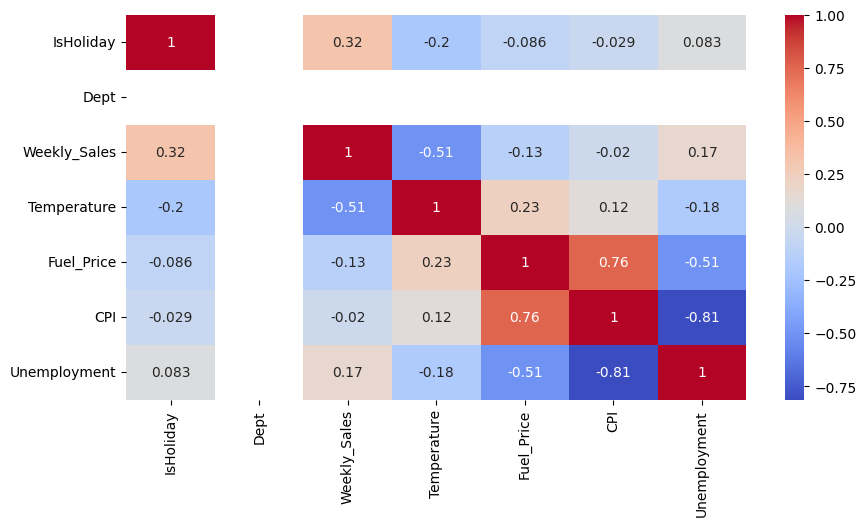

In [14]:
# Checking correlation
plt.figure(figsize=(10,5))
plt.grid(False)
sns.heatmap(dep5_df.corr(), annot=True, cmap='coolwarm')

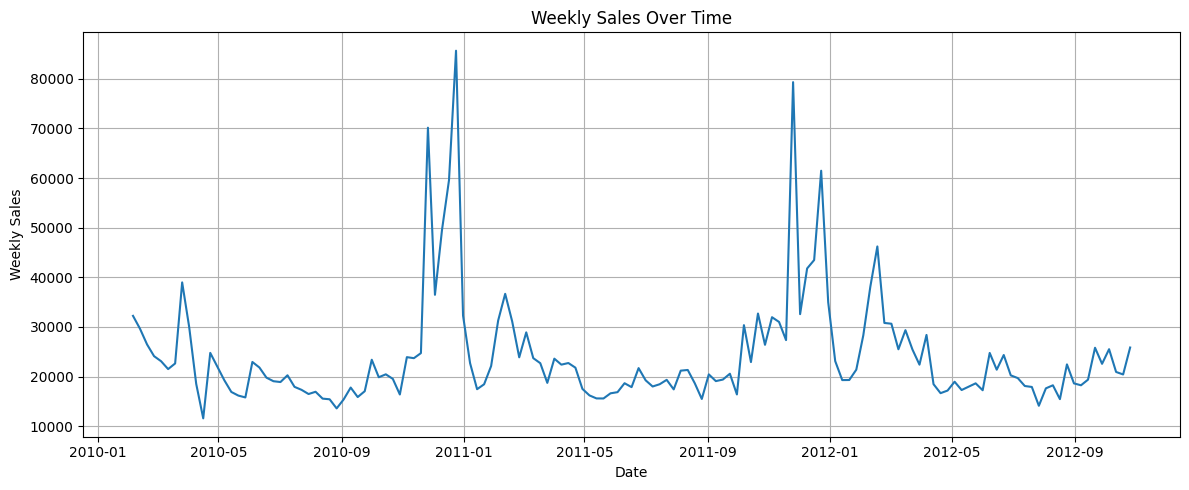

In [13]:
# Plot Weekly Sales
plt.figure(figsize=(12, 5))
sns.lineplot(data=dep5_df, x=dep5_df.index, y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

- Visualize other variables for trends

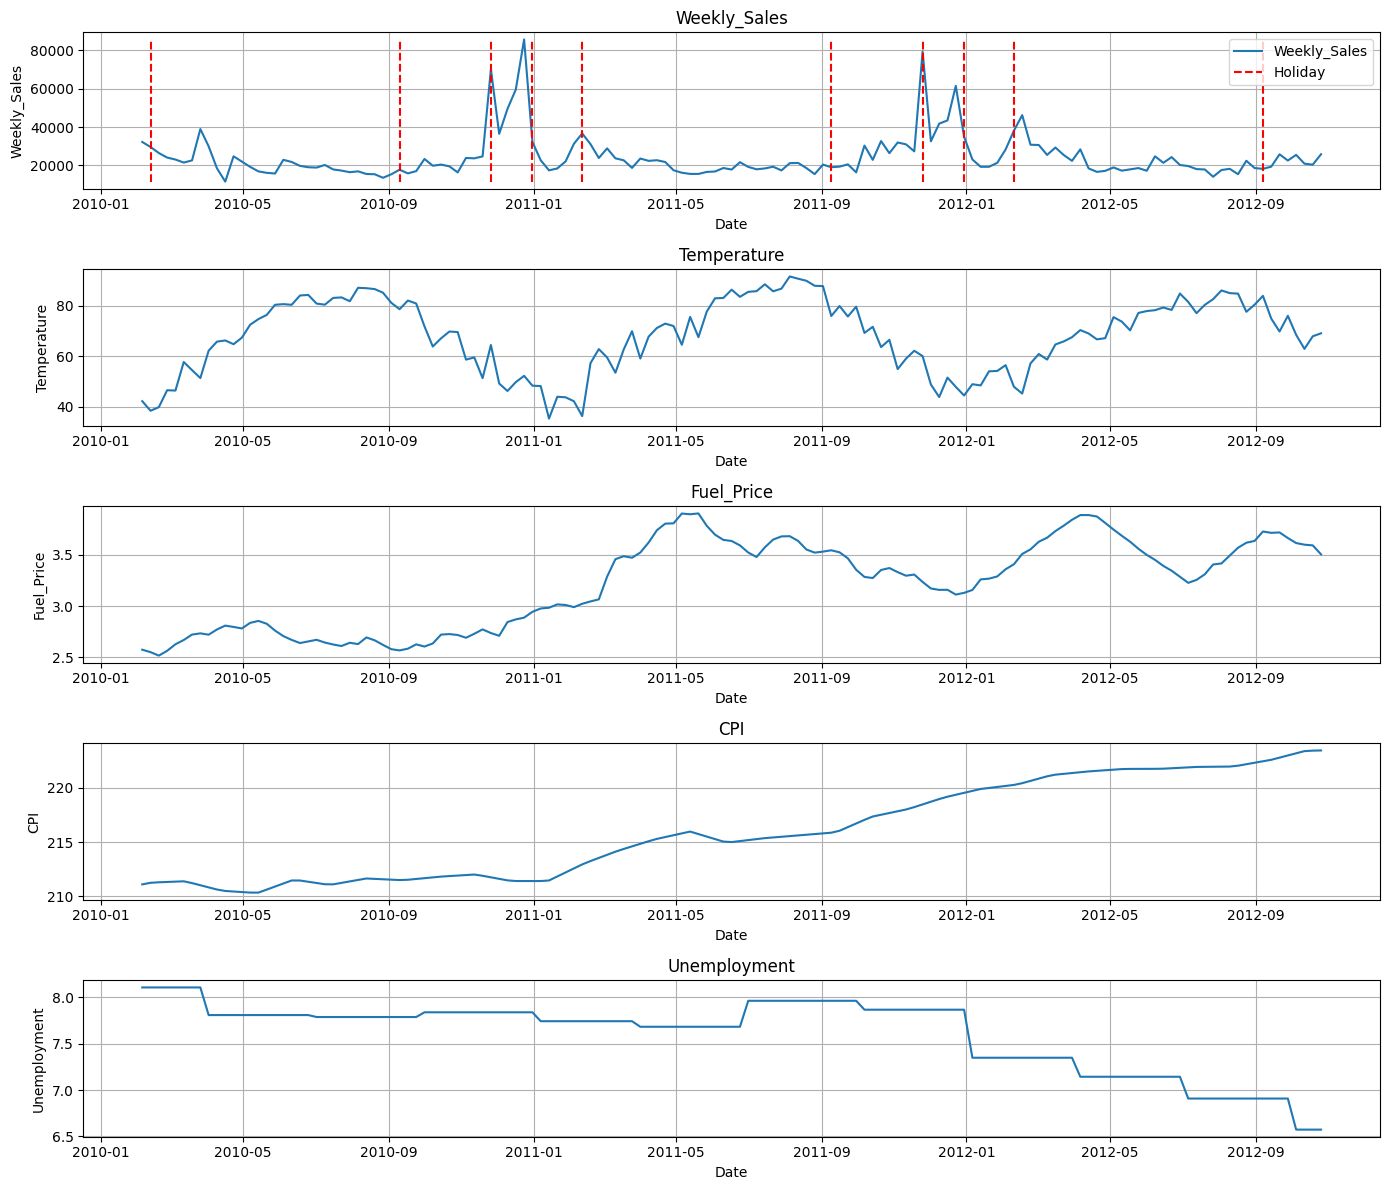

In [15]:
# List of numeric columns to plot
columns_to_plot = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Set figure size and layout
plt.figure(figsize=(14, 12))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 1, i)
    plt.plot(dep5_df.index, dep5_df[col], label=col, color='tab:blue')
    
    # Highlight holiday weeks
    if col == 'Weekly_Sales':
        holiday_weeks = dep5_df[dep5_df['IsHoliday'] == 1].index
        plt.vlines(holiday_weeks, ymin=dep5_df[col].min(), ymax=dep5_df[col].max(), 
                   colors='red', linestyles='dashed', label='Holiday')
    
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    if i == 1:
        plt.legend()

plt.show()


---

#### **Time Series Analysis**

- Decompose Time Series (Weekly_Sales)

<Figure size 1400x1000 with 0 Axes>

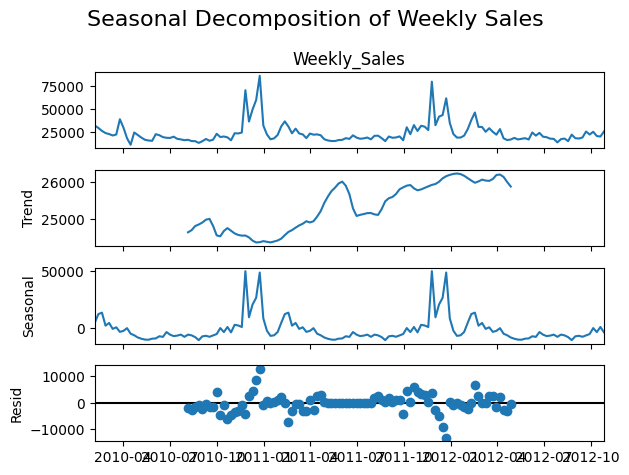

In [12]:
# break time series into trend (long term progression), seasonality (repeating pattern), and residual (random noise)
sales_series = dep5_df['Weekly_Sales'].dropna()
decomposition = seasonal_decompose(sales_series, model='additive', period=52)  # 52 weeks in a year

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=16)
plt.tight_layout()
plt.show()

- ADF Stationarity Test

In [21]:
# Perform ADF test
adf_result = adfuller(sales_series)

# Display results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")
    
if adf_result[1] < 0.05:
    print("\nThe series is stationary (reject H₀).")
else:
    print("\nThe series is not stationary (fail to reject H₀).")


ADF Statistic: -2.9319136246227653
p-value: 0.04176075421044796
Critical Values:
   1%: -3.4793722137854926
   5%: -2.8830370378332995
   10%: -2.578233635380623

The series is stationary (reject H₀).


- Plot ACF and PACF

In [23]:
dep5_df.columns

Index(['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

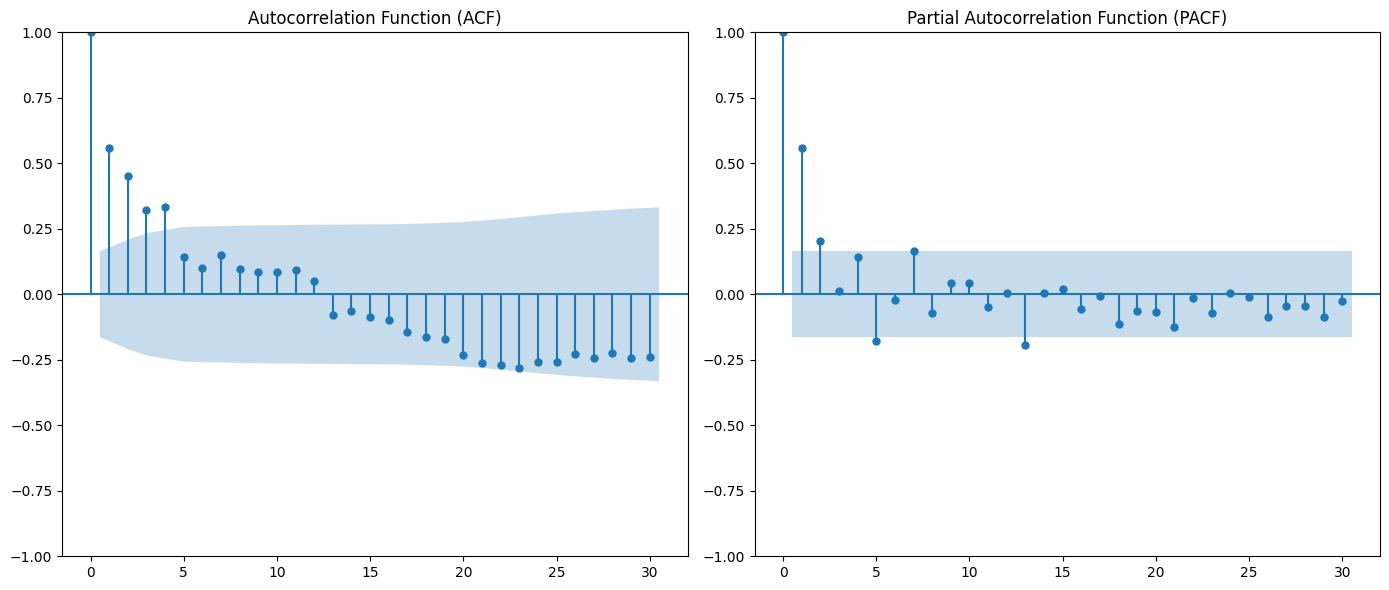

In [24]:
series_to_use = dep5_df['Weekly_Sales'].dropna()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(series_to_use, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
plot_pacf(series_to_use, lags=30, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


---

#### **Train-Test Split**

In [13]:
train_size = int(len(dep5_df) * 0.8)
train_size

114

In [14]:
train, test = dep5_df['Weekly_Sales'][:train_size], dep5_df['Weekly_Sales'][train_size:]
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (114,)
test shape: (29,)


---

#### **Exponential Smoothing**

- Holt's Linear Trend

c:\Users\Hend-PC\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


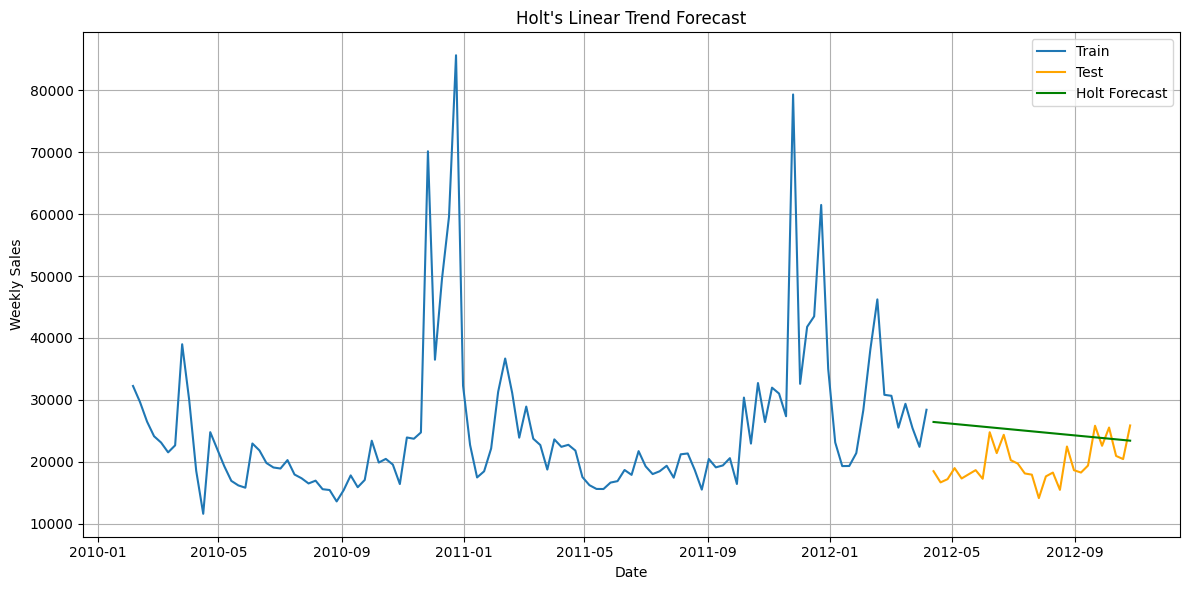

In [29]:
# fit model
holt_model = Holt(train).fit()
# forecast
forecast = holt_model.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Holt Forecast', color='green')
plt.title("Holt's Linear Trend Forecast")
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 6235.97
MAE: 5536.31


- Holt-Winters (Seasonal Exponential Smoothing)

c:\Users\Hend-PC\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


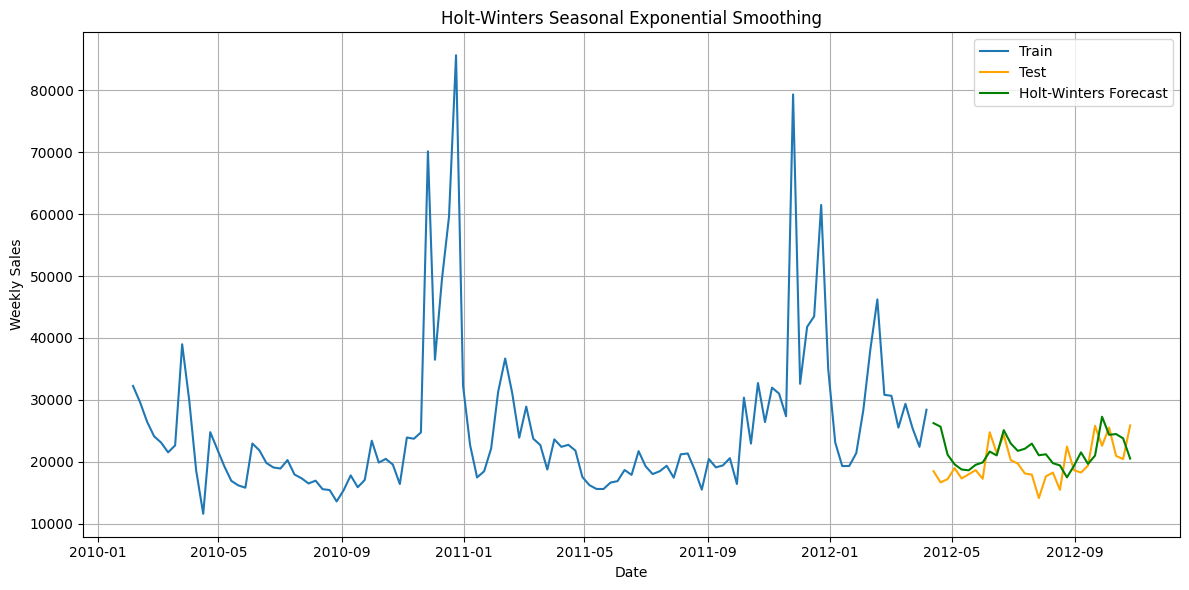

In [32]:
# fit model
# weekly data with yearly seasonality → period = 52
hw_model = ExponentialSmoothing(train,
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=52).fit()
# forecast
hw_forecast = hw_model.forecast(len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title("Holt-Winters Seasonal Exponential Smoothing")
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))
mae_hw = mean_absolute_error(test, hw_forecast)
print(f'RMSE: {rmse_hw:.2f}')
print(f'MAE: {mae_hw:.2f}')

RMSE: 3914.78
MAE: 3208.34


---

#### **ARIMA Family**

- ARIMA

In [37]:
stepwise_model = auto_arima(dep5_df['Weekly_Sales'],
                            seasonal=False,  # No seasonality for ARIMA
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3038.598, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3323.456, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3058.046, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3248.443, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3036.901, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3217.219, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3035.450, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3036.005, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3040.899, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3025.034, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3051.596, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3027.681, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3025.570, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3026.648, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1507.784
Date:                Fri, 20 Jun 2025   AIC                           3023.568
Time:                        21:53:18   BIC                           3035.419
Sample:                    02-05-2010   HQIC                          3028.384
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8482.5351   2051.567      4.135      0.000    4461.538    1.25e+04
ar.L1          0.4441      0.051      8.754      0.000       0.345       0.544
ar.L2          0.2070      0.065      3.161      0.002       0.079       0.335
sigma2      8.492e+07      0.590   1.44e+08      0.000    8.49e+07    8.49e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1200.94
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.53e+27. Standard errors may be unstable.
"""

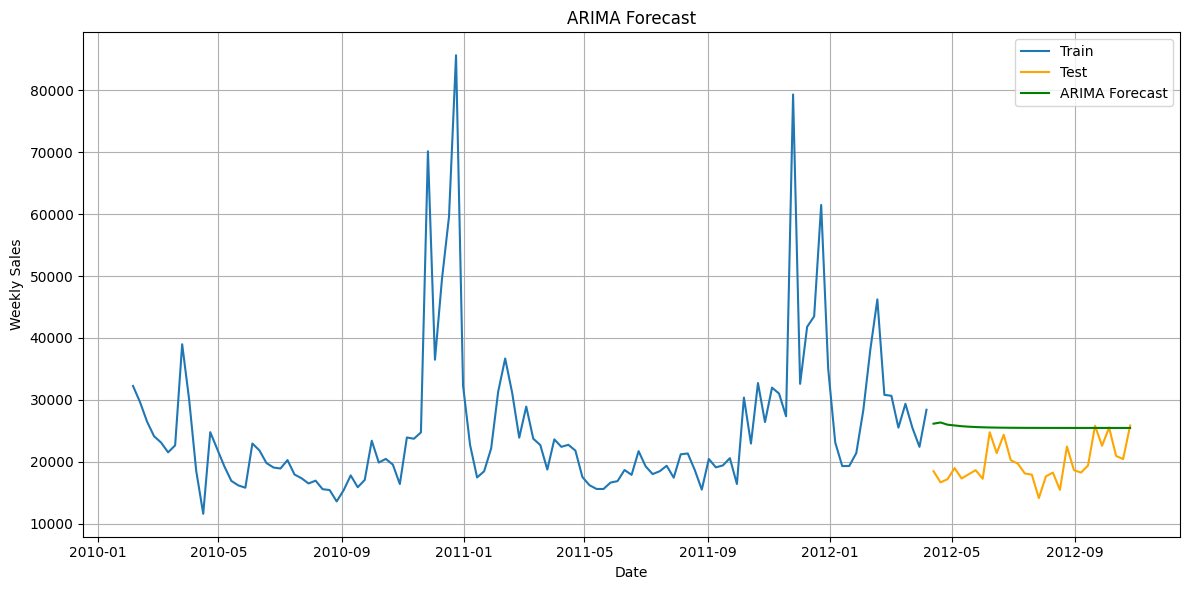

In [38]:
# fit model
arima_model = auto_arima(train, seasonal=False).fit(train)
# forecast
forecast = arima_model.predict(n_periods=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
mae_arima = mean_absolute_error(test, forecast)
print(f'RMSE: {rmse_arima:.2f}')
print(f'MAE: {mae_arima:.2f}')

RMSE: 6587.50
MAE: 5836.02


- SARIMA (Seasonality)

In [40]:
sarima_model = auto_arima(dep5_df['Weekly_Sales'],
                          seasonal=True,
                          m=52,  # Weekly data → yearly seasonality
                          trace=True,
                          suppress_warnings=True,
                          stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2988.699, Time=1.66 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3078.690, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3000.331, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3026.792, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3323.456, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2995.514, Time=1.07 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2986.726, Time=2.43 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3026.394, Time=0.10 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2988.726, Time=5.68 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2990.408, Time=5.79 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2989.622, Time=1.88 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2986.482, Time=1.74 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=3025.570, Time=0.05 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=2988.474, Time=5.34 sec
 ARIMA(2,0,1)(1,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood               -1471.141
Date:                             Fri, 20 Jun 2025   AIC                           2952.282
Time:                                     21:56:59   BIC                           2967.096
Sample:                                 02-05-2010   HQIC                          2958.301
                                      - 10-26-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4584      0.052     28.249      0.000       1.357       1.560
ar.L2         -0.4589      0.051     -9.015      0.000      -0.559      -0.359
ma.L1         -0.9892      0.035    -28.338      0.000      -1.058      -0.921
ar.S.L52       0.8561      0.013     65.750      0.000       0.831       0.882
sigma2      3.046e+07   3.93e-10   7.75e+16      0.000    3.05e+07    3.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               160.64
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             1.12
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.83e+32. Standard errors may be unstable.
"""

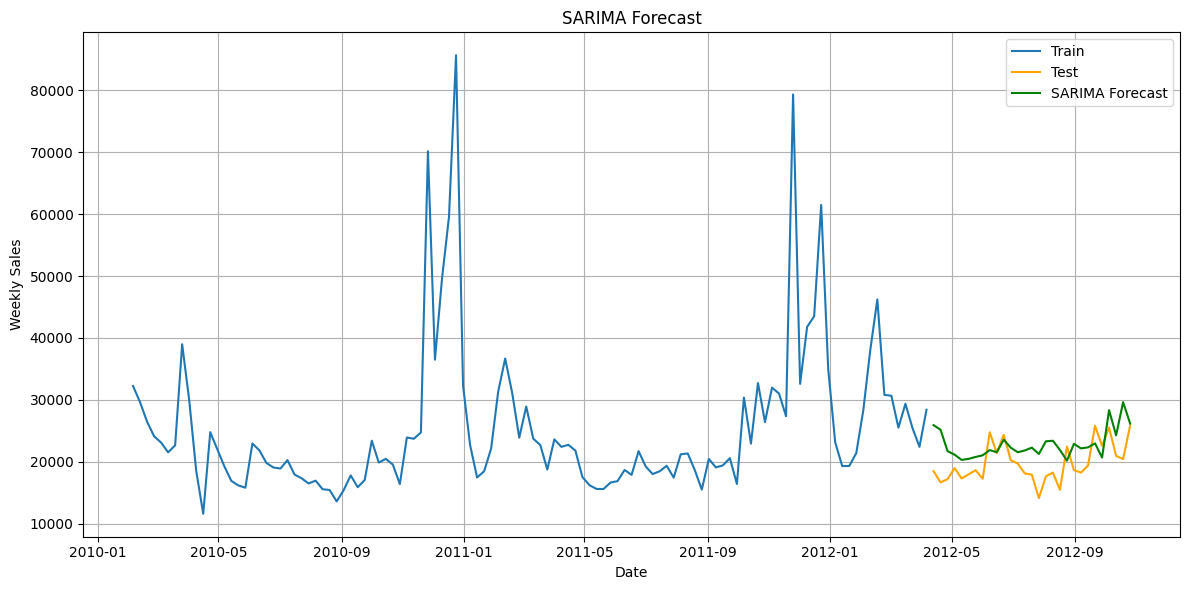

In [41]:
# fit model
sarima_model = auto_arima(train,
                          seasonal=True,
                          m=52,
                          trace=False,
                          suppress_warnings=True).fit(train)
# forecast
sarima_forecast = sarima_model.predict(n_periods=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast))
mae_sarima = mean_absolute_error(test, sarima_forecast)
print(f'RMSE: {rmse_sarima:.2f}')
print(f'MAE: {mae_sarima:.2f}')

RMSE: 4355.10
MAE: 3724.01


- SARIMAX (adding external regressors)

In [44]:
dep5_df.columns

Index(['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In [45]:
target = 'Weekly_Sales'
exog_vars = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']

In [47]:
train_size = int(len(dep5_df) * 0.8)
train = dep5_df.iloc[:train_size]
test = dep5_df.iloc[train_size:]

In [48]:
# Split exogenous variables
exog_train = train[exog_vars]
exog_test = test[exog_vars]

In [49]:
sarimax_model = SARIMAX(train[target],
                        exog=exog_train,
                        order=(1,1,1),
                        seasonal_order=(1,1,1,52),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                 -68.327
Date:                            Fri, 20 Jun 2025   AIC                            156.653
Time:                                    22:01:05   BIC                            156.112
Sample:                                02-05-2010   HQIC                           149.968
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature   -391.6227    1.4e+04     -0.028      0.978   -2.79e+04    2.71e+04
Fuel_Price    9575.9495   3.23e+05      0.030      0.976   -6.24e+05    6.44e+05
CPI           -233.9739   1.41e+05     -0.002      0.999   -2.77e+05    2.77e+05
Unemployment -3136.3037   2.67e+04     -0.117      0.907   -5.55e+04    4.92e+04
IsHoliday     2.028e-07    358.333   5.66e-10      1.000    -702.319     702.319
ar.L1           -0.1838     33.681     -0.005      0.996     -66.197      65.829
ma.L1           -0.9668     11.862     -0.082      0.935     -24.216      22.283
ar.S.L52        -0.0996     49.166     -0.002      0.998     -96.463      96.264
ma.S.L52         0.0658     45.513      0.001      0.999     -89.139      89.270
sigma2        4.303e+07   1012.224   4.25e+04      0.000     4.3e+07     4.3e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.68   Prob(JB):                         0.85
Heteroskedasticity (H):               1.92   Skew:                             0.21
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.77e+21. Standard errors may be unstable.
"""

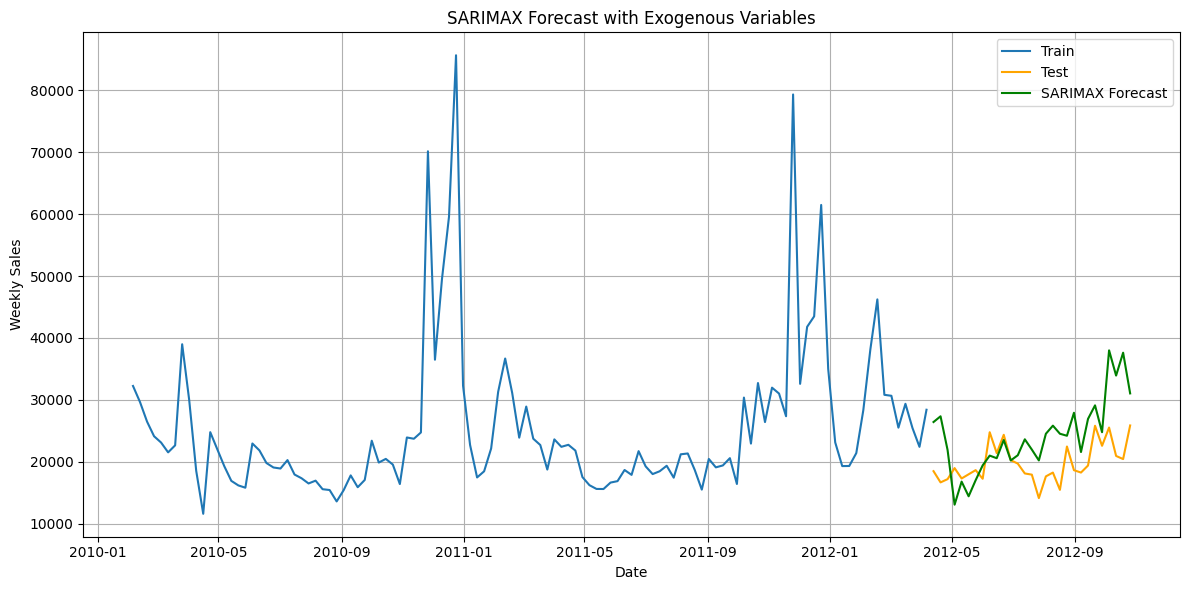

In [50]:
# Forecast
sarimax_forecast = sarimax_model.predict(start=test.index[0],
                                         end=test.index[-1],
                                         exog=exog_test)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train[target], label='Train')
plt.plot(test.index, test[target], label='Test', color='orange')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='green')
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
rmse_sarimax = np.sqrt(mean_squared_error(test[target], sarimax_forecast))
mae_sarimax = mean_absolute_error(test[target], sarimax_forecast)
print(f'RMSE: {rmse_sarimax:.2f}')
print(f'MAE: {mae_sarimax:.2f}')

RMSE: 6855.05
MAE: 5460.02


---

#### **Machine Learning Regressors**

In [ ]:
ml_df = dep5_df.copy()

# Creating lag features (previous 1 to 3 weeks' sales)
for lag in range(1, 4):
    ml_df[f'lag_{lag}'] = ml_df['Weekly_Sales'].shift(lag)

ml_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Freq: W-FRI
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     143 non-null    int64  
 1   Dept          143 non-null    float64
 2   Weekly_Sales  143 non-null    float64
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
 7   lag_1         142 non-null    float64
 8   lag_2         141 non-null    float64
 9   lag_3         140 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 12.3 KB


In [53]:
# drop nulls caused by lags
ml_df.dropna(inplace=True)

In [54]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2010-02-26 to 2012-10-26
Freq: W-FRI
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     140 non-null    int64  
 1   Dept          140 non-null    float64
 2   Weekly_Sales  140 non-null    float64
 3   Temperature   140 non-null    float64
 4   Fuel_Price    140 non-null    float64
 5   CPI           140 non-null    float64
 6   Unemployment  140 non-null    float64
 7   lag_1         140 non-null    float64
 8   lag_2         140 non-null    float64
 9   lag_3         140 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 12.0 KB


In [55]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
            'lag_1', 'lag_2', 'lag_3']
target = 'Weekly_Sales'

train_size = int(len(ml_df) * 0.8)
train_ml = ml_df.iloc[:train_size]
test_ml = ml_df.iloc[train_size:]

X_train = train_ml[features]
y_train = train_ml[target]
X_test = test_ml[features]
y_test = test_ml[target]

- Random Forest

In [57]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
mae_rf = mean_absolute_error(y_test, rf_preds)
print(f'Random Forest RMSE: {rmse_rf:.2f}')
print(f'Random Forest MAE: {mae_rf:.2f}')

Random Forest RMSE: 3772.52
Random Forest MAE: 3366.71


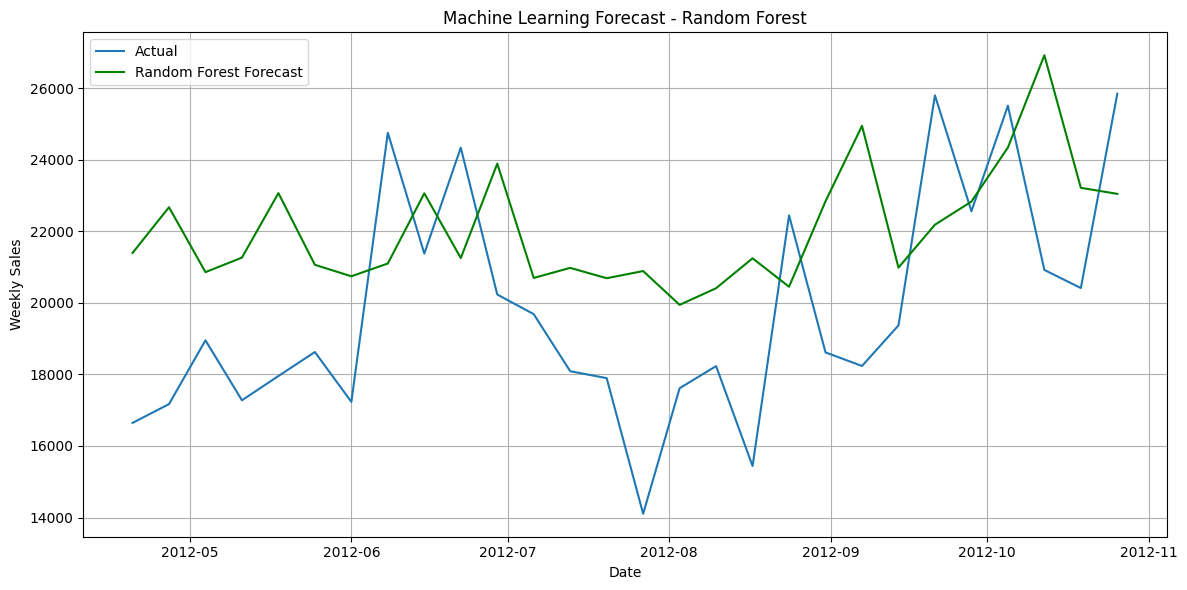

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(test_ml.index, y_test, label='Actual')
plt.plot(test_ml.index, rf_preds, label='Random Forest Forecast', color='green')
plt.title('Machine Learning Forecast - Random Forest')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Linear Regression

In [59]:
lr = LinearRegression().fit(X_train, y_train)
lr_preds = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_preds))
mae_lr = mean_absolute_error(y_test, lr_preds)
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression MAE: {mae_lr:.2f}')

Linear Regression RMSE: 4062.91
Linear Regression MAE: 3194.49


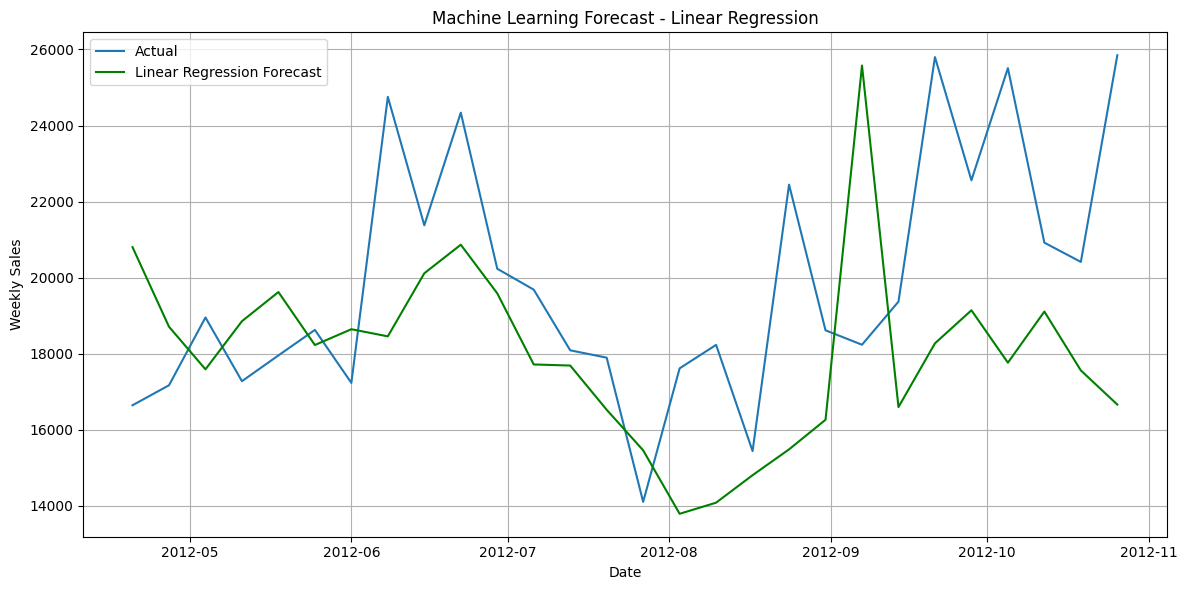

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(test_ml.index, y_test, label='Actual')
plt.plot(test_ml.index, lr_preds, label='Linear Regression Forecast', color='green')
plt.title('Machine Learning Forecast - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- XGBoost

In [61]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
mae_xgb = mean_absolute_error(y_test, xgb_preds)
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'XGBoost MAE: {mae_xgb:.2f}')

XGBoost RMSE: 8751.73
XGBoost MAE: 6656.37


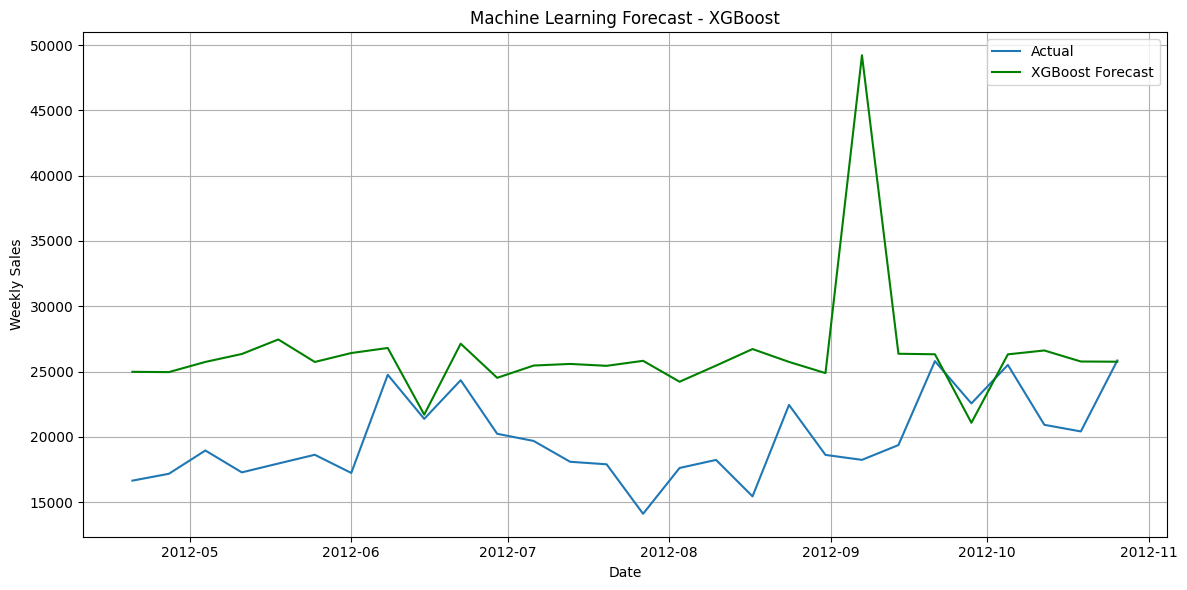

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(test_ml.index, y_test, label='Actual')
plt.plot(test_ml.index, xgb_preds, label='XGBoost Forecast', color='green')
plt.title('Machine Learning Forecast - XGBoost')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- SVR

In [65]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, epsilon=10))
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, svr_preds))
mae_svr = mean_absolute_error(y_test, svr_preds)
print(f'SVR RMSE: {rmse_svr:.2f}')
print(f'SVR MAE: {mae_svr:.2f}')


SVR RMSE: 4099.42
SVR MAE: 3642.04


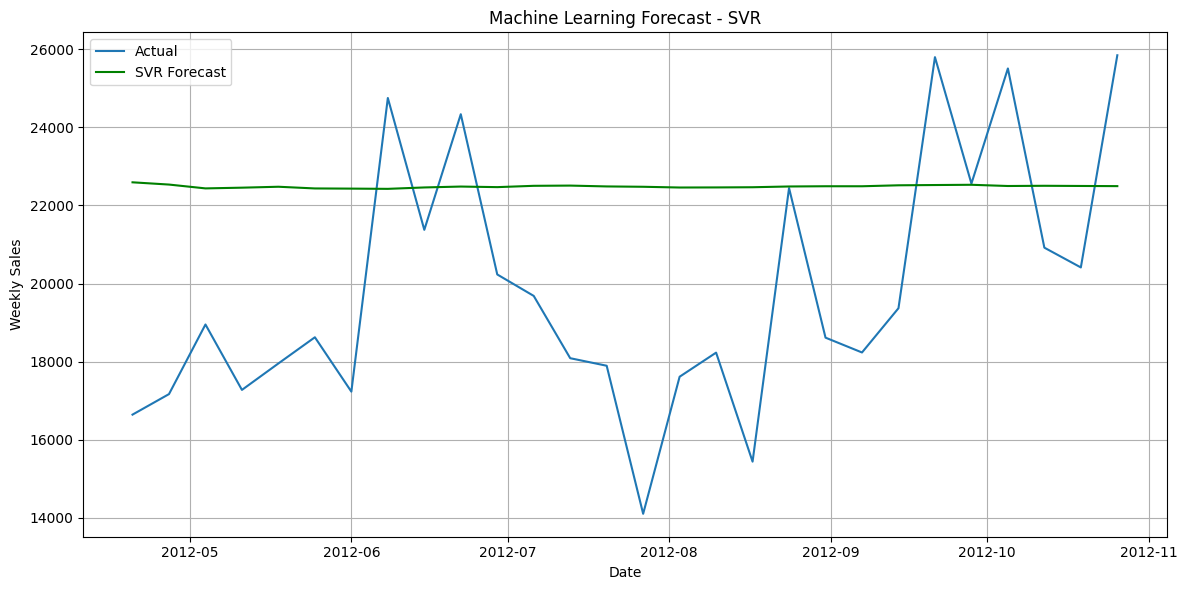

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(test_ml.index, y_test, label='Actual')
plt.plot(test_ml.index, svr_preds, label='SVR Forecast', color='green')
plt.title('Machine Learning Forecast - SVR')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Compare All ML Models

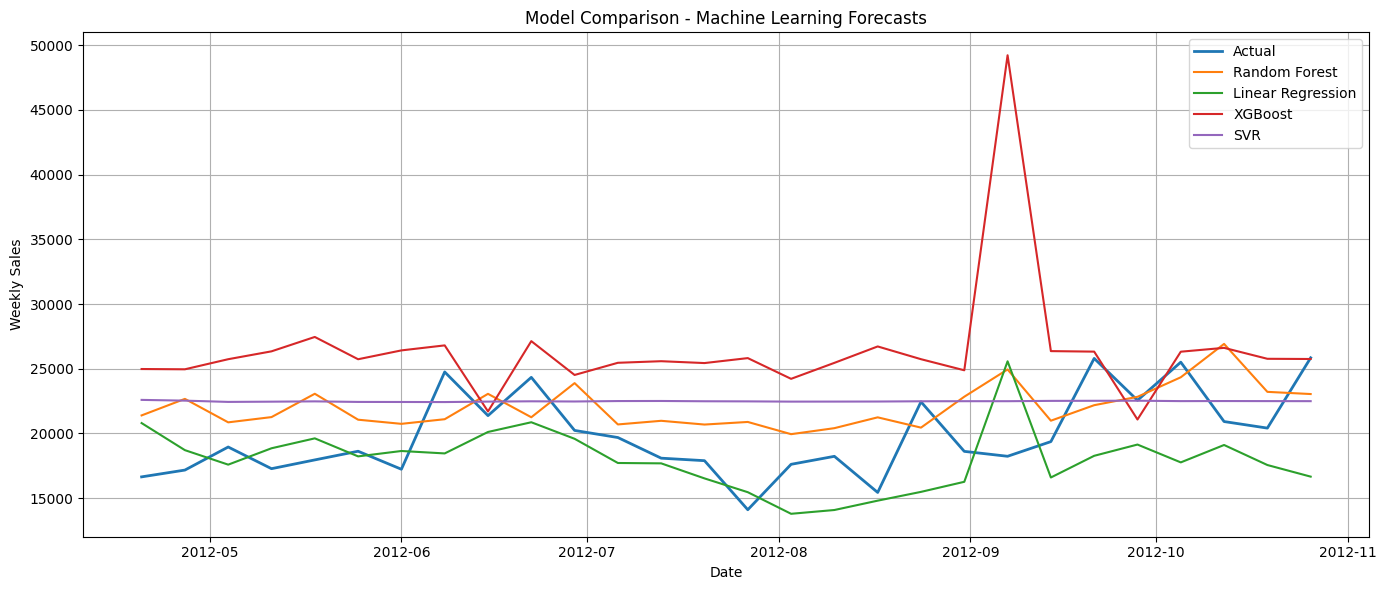

In [67]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, rf_preds, label='Random Forest')
plt.plot(y_test.index, lr_preds, label='Linear Regression')
plt.plot(y_test.index, xgb_preds, label='XGBoost')
plt.plot(y_test.index, svr_preds, label='SVR')
plt.title('Model Comparison - Machine Learning Forecasts')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Random Forest with Recursive Forecasting

Since Random Forest was the best ML Model

In [68]:
def recursive_forecast(model, last_known_df, exog_future, forecast_steps=10):
    predictions = []
    lags = list(last_known_df[['lag_1', 'lag_2', 'lag_3']].iloc[-1])

    for i in range(forecast_steps):
        exog_row = exog_future.iloc[i]
        input_features = list(exog_row) + lags
        input_df = pd.DataFrame([input_features], columns=exog_future.columns.tolist() + ['lag_1', 'lag_2', 'lag_3'])

        pred = model.predict(input_df)[0]
        predictions.append(pred)

        lags = [pred] + lags[:-1]  # update lag_1, lag_2, lag_3

    return predictions

In [81]:
# Forecast n steps ahead
n_steps = 10

# Use last row with lags
last_known_rf = ml_df.copy().iloc[-1:]

# Simulate future exogenous variables (repeat last values)
exog_future_rf = last_known_rf[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']].copy()
exog_future_rf = pd.concat([exog_future_rf] * n_steps).reset_index(drop=True)

# Forecast
rf_recursive_preds = recursive_forecast(model=rf, 
                                        last_known_df=ml_df, 
                                        exog_future=exog_future_rf, 
                                        forecast_steps=n_steps)

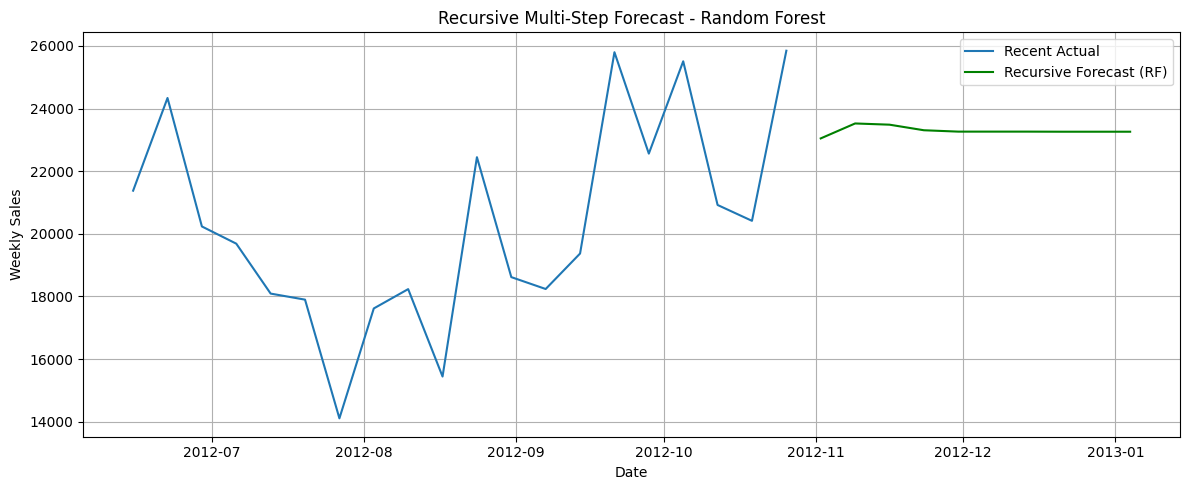

In [82]:
future_dates = pd.date_range(start=ml_df.index[-1] + pd.Timedelta(weeks=1), periods=n_steps, freq='W-FRI')

plt.figure(figsize=(12, 5))
plt.plot(ml_df.index[-20:], ml_df['Weekly_Sales'].tail(20), label='Recent Actual')
plt.plot(future_dates, rf_recursive_preds, label='Recursive Forecast (RF)', color='green')
plt.title('Recursive Multi-Step Forecast - Random Forest')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Save the model
joblib.dump(rf, 'random_forest_model.pkl')

---

#### **Deep Learning Models**

- FeedForward NN (ANN)

In [84]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
            'lag_1', 'lag_2', 'lag_3']
target = 'Weekly_Sales'

train_size = int(len(ml_df) * 0.8)
train = ml_df.iloc[:train_size]
test = ml_df.iloc[train_size:]

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

In [86]:
# build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [87]:
# train
history = model.fit(X_train, y_train, epochs=100, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 728077376.0000 - val_loss: 132335600.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 260339008.0000 - val_loss: 20801894.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 174063216.0000 - val_loss: 11755610.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 101635008.0000 - val_loss: 11104381.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 155278208.0000 - val_loss: 11424023.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 143738464.0000 - val_loss: 12821911.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 151352640.0000 - val_loss: 12577874.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 112746312.0000 - val_loss: 9966424.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 136782240.0000 - val_loss: 10827349.0000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 70565688.0000 - val_loss: 10529415.0000

In [88]:
nn_preds = model.predict(X_test).flatten()

rmse_nn = np.sqrt(mean_squared_error(y_test, nn_preds))
mae_nn = mean_absolute_error(y_test, nn_preds)
print(f"Neural Network RMSE: {rmse_nn:.2f}")
print(f"Neural Network MAE: {mae_nn:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Neural Network RMSE: 3186.07
Neural Network MAE: 2561.58


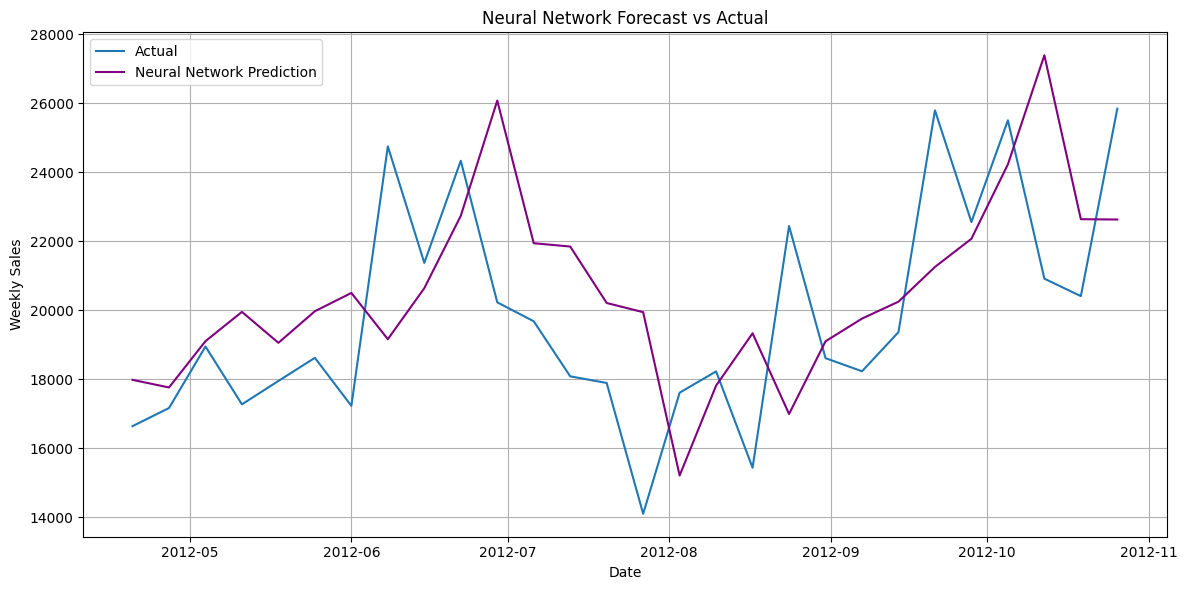

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, nn_preds, label='Neural Network Prediction', color='purple')
plt.title('Neural Network Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- CNN

In [108]:
# Reshape X for CNN/RNN/LSTM/GRU: (samples, timesteps=1, features)
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [112]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [113]:
cnn_model.fit(X_train_seq, y_train, epochs=100, batch_size=8,
              validation_data=(X_test_seq, y_test), verbose=1)
cnn_preds = cnn_model.predict(X_test_seq).flatten()
rmse_cnn = np.sqrt(mean_squared_error(y_test, cnn_preds))
mae_cnn = mean_absolute_error(y_test, cnn_preds)
print(f"CNN RMSE: {rmse_cnn:.2f}")
print(f"CNN MAE: {mae_cnn:.2f}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 796032320.0000 - val_loss: 152500528.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 297363936.0000 - val_loss: 33166542.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 167515504.0000 - val_loss: 10485062.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 126553952.0000 - val_loss: 10318627.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 139652336.0000 - val_loss: 10407103.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 124560952.0000 - val_loss: 11000269.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 83982456.0000 - val_loss: 10905288.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 122150120.0000 - val_loss: 10566981.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 154520256.0000 - val_loss: 10334208.0000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78874936.0000 - val_loss: 1053

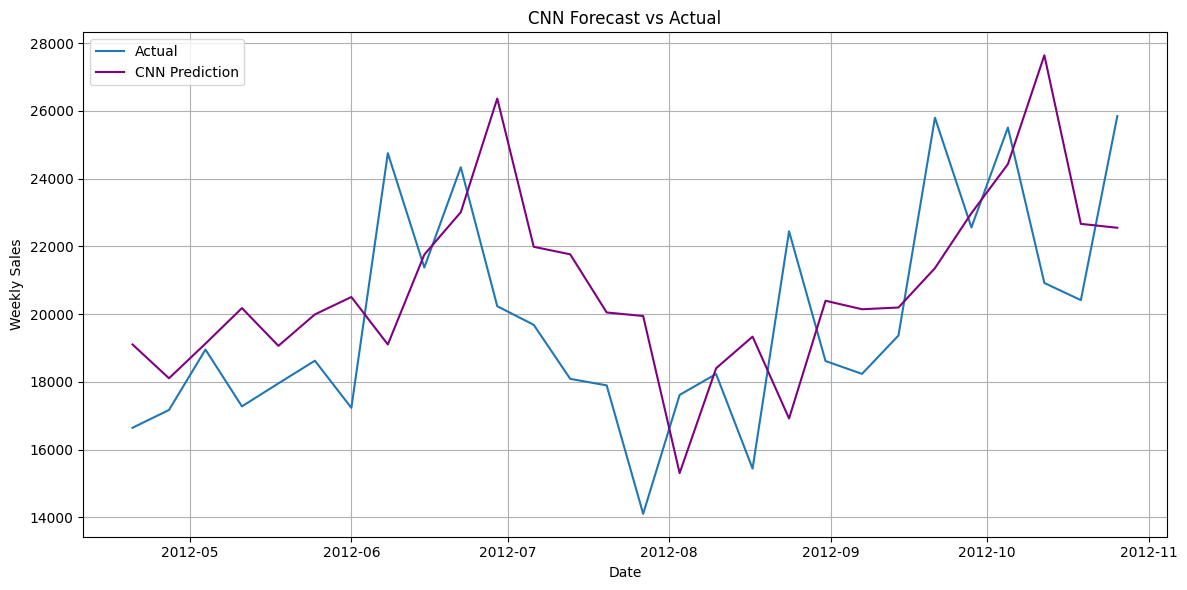

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, cnn_preds, label='CNN Prediction', color='purple')
plt.title('CNN Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- RNN

In [116]:
rnn_model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(1, X_train.shape[1])),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
rnn_model.fit(X_train_seq, y_train, epochs=100, batch_size=8,
              validation_data=(X_test_seq, y_test), verbose=1)

rnn_preds = rnn_model.predict(X_test_seq).flatten()
rmse_rnn = np.sqrt(mean_squared_error(y_test, rnn_preds))
mae_rnn = mean_absolute_error(y_test, rnn_preds)
print(f"RNN RMSE: {rmse_rnn:.2f}")
print(f"RNN MAE: {mae_rnn:.2f}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 817321984.0000 - val_loss: 403116384.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 790317888.0000 - val_loss: 403022112.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 646595072.0000 - val_loss: 402919456.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 747858816.0000 - val_loss: 402792288.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 807531136.0000 - val_loss: 402641728.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 759395200.0000 - val_loss: 402467104.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 752891072.0000 - val_loss: 402267680.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 707602816.0000 - val_loss: 402037728.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 883641088.0000 - val_loss: 401776992.0000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 779366912.0000 - val_lo

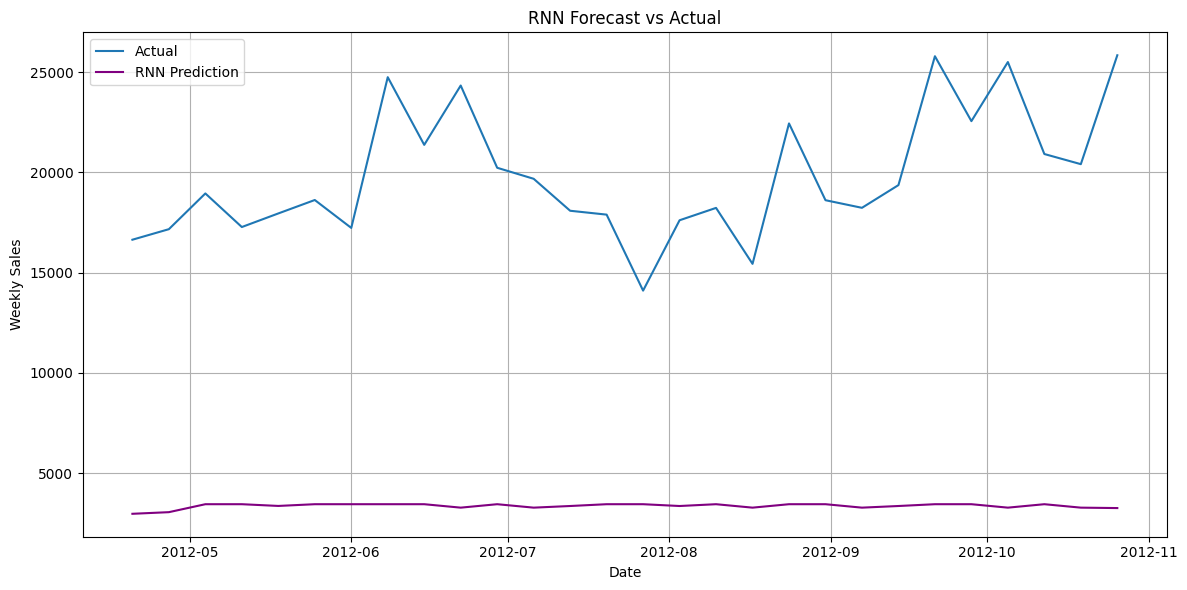

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, rnn_preds, label='RNN Prediction', color='purple')
plt.title('RNN Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- LSTM

In [92]:
lstm_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(1, X_train.shape[1])),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [93]:
lstm_model.fit(X_train_seq, y_train, epochs=100, batch_size=8,
               validation_data=(X_test_seq, y_test), verbose=1)

lstm_preds = lstm_model.predict(X_test_seq).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_preds))
mae_lstm = mean_absolute_error(y_test, lstm_preds)
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 935464704.0000 - val_loss: 403086112.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 765227904.0000 - val_loss: 403048288.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 684815552.0000 - val_loss: 403003072.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 816064320.0000 - val_loss: 402946496.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 798437312.0000 - val_loss: 402880448.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 743022400.0000 - val_loss: 402804320.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 743662848.0000 - val_loss: 402714688.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 675897472.0000 - val_loss: 402603808.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 791271744.0000 - val_loss: 402474944.0000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 798254784.0000 - val_loss: 402

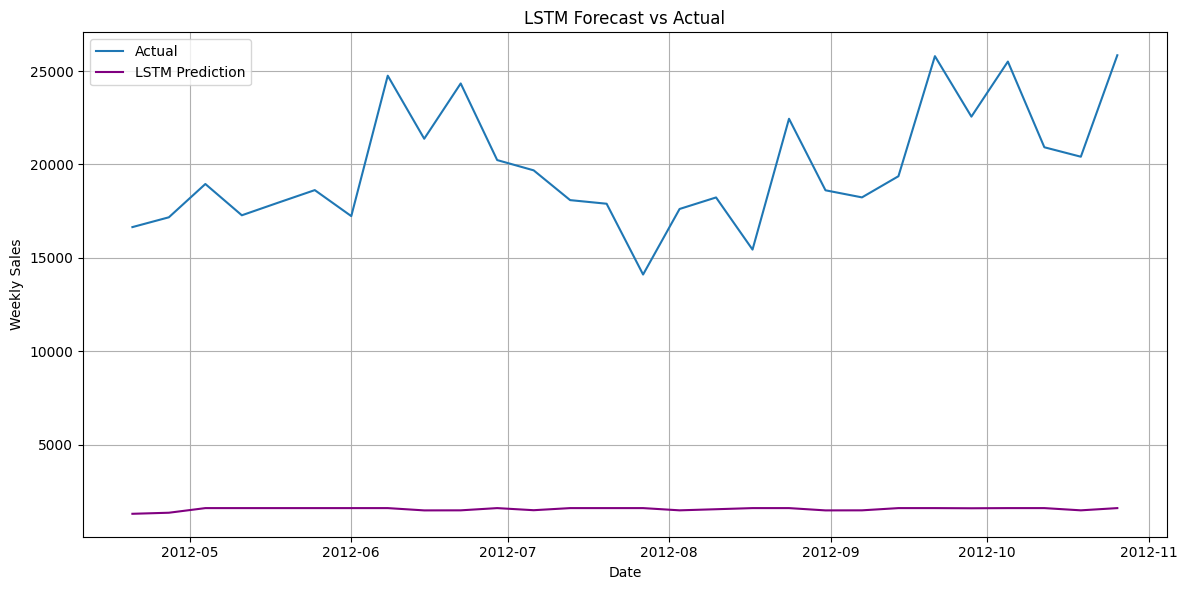

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, lstm_preds , label='LSTM Prediction', color='purple')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- GRU

In [96]:
gru_model = Sequential([
    GRU(64, activation='tanh', input_shape=(1, X_train.shape[1])),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [97]:
gru_model.fit(X_train_seq, y_train, epochs=100, batch_size=8,
              validation_data=(X_test_seq, y_test), verbose=1)

gru_preds = gru_model.predict(X_test_seq).flatten()

rmse_gru = np.sqrt(mean_squared_error(y_test, gru_preds))
mae_gru = mean_absolute_error(y_test, gru_preds)
print(f"GRU RMSE: {rmse_gru:.2f}")
print(f"GRU MAE: {mae_gru:.2f}")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 987035968.0000 - val_loss: 403056640.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 799960960.0000 - val_loss: 402980512.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 942528640.0000 - val_loss: 402905152.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1029261824.0000 - val_loss: 402811552.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 772842240.0000 - val_loss: 402678336.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 692593728.0000 - val_loss: 402532672.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 688932608.0000 - val_loss: 402363200.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 711942784.0000 - val_loss: 402180288.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 950461056.0000 - val_loss: 401976224.0000
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 951005824.0000 - val_loss: 40

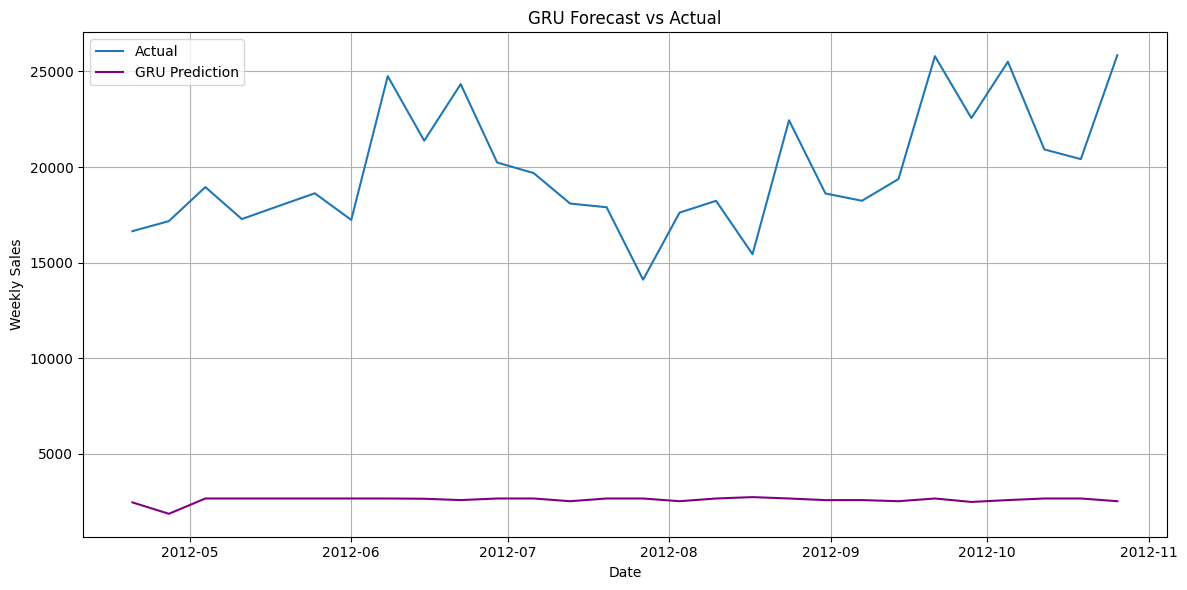

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, gru_preds , label='GRU Prediction', color='purple')
plt.title('GRU Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Comparing Deep Learning Models

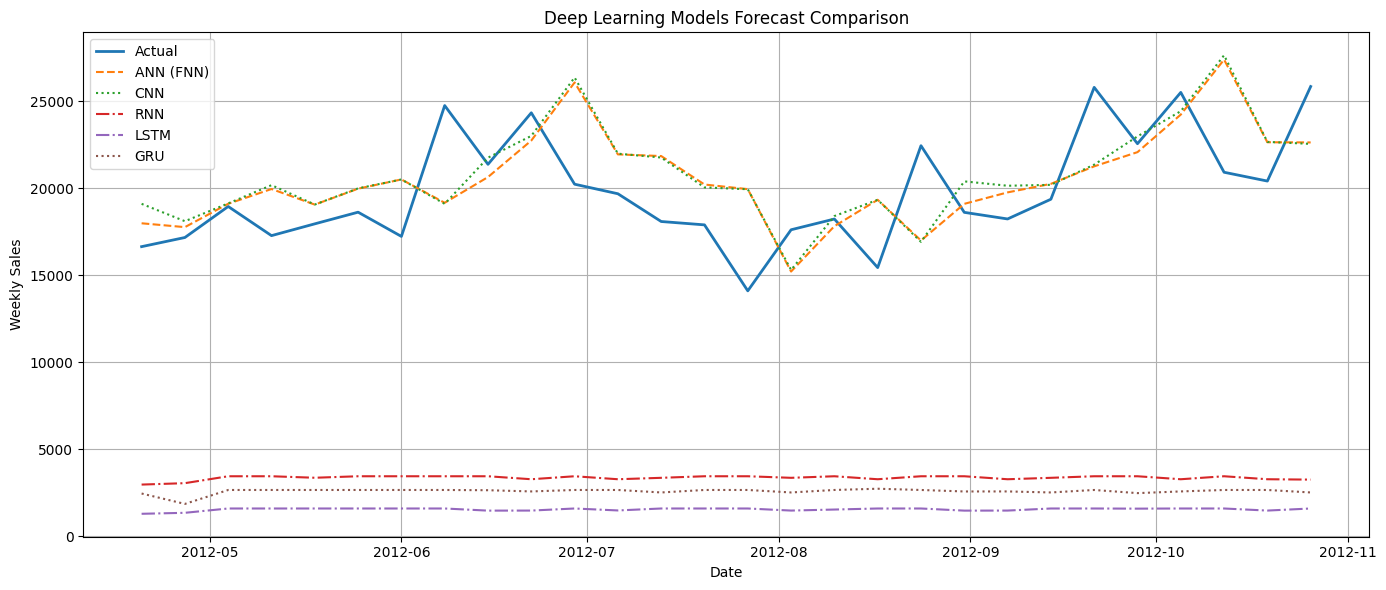

In [120]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, y_test, label='Actual', linewidth=2)
plt.plot(test.index, nn_preds, label='ANN (FNN)', linestyle='--')
plt.plot(test.index, cnn_preds, label='CNN', linestyle='dotted')
plt.plot(test.index, rnn_preds, label='RNN', linestyle='-.')
plt.plot(test.index, lstm_preds, label='LSTM', linestyle='-.')
plt.plot(test.index, gru_preds, label='GRU', linestyle=':')
plt.title('Deep Learning Models Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- FNN with Recursive Forcasting

since it is the best DL model

In [100]:
def recursive_forecast_nn(model, last_known_df, exog_future, forecast_steps=10):
    predictions = []
    lags = list(last_known_df[['lag_1', 'lag_2', 'lag_3']].iloc[-1])

    for i in range(forecast_steps):
        exog_row = exog_future.iloc[i]
        input_features = list(exog_row) + lags
        input_array = np.array(input_features).reshape(1, -1)

        # Predict
        pred = model.predict(input_array, verbose=0)[0][0]
        predictions.append(pred)

        # Update lags
        lags = [pred] + lags[:-1]

    return predictions


In [104]:
# Number of future steps to forecast
n_steps = 10

# Last known data point with lags
last_known_nn = ml_df.copy().iloc[-1:]

# Future exogenous inputs
exog_future_nn = last_known_nn[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']].copy()
exog_future_nn = pd.concat([exog_future_nn] * n_steps).reset_index(drop=True)

# Forecast using recursive strategy
nn_recursive_preds = recursive_forecast_nn(model=model,
                                           last_known_df=ml_df,
                                           exog_future=exog_future_nn,
                                           forecast_steps=n_steps)


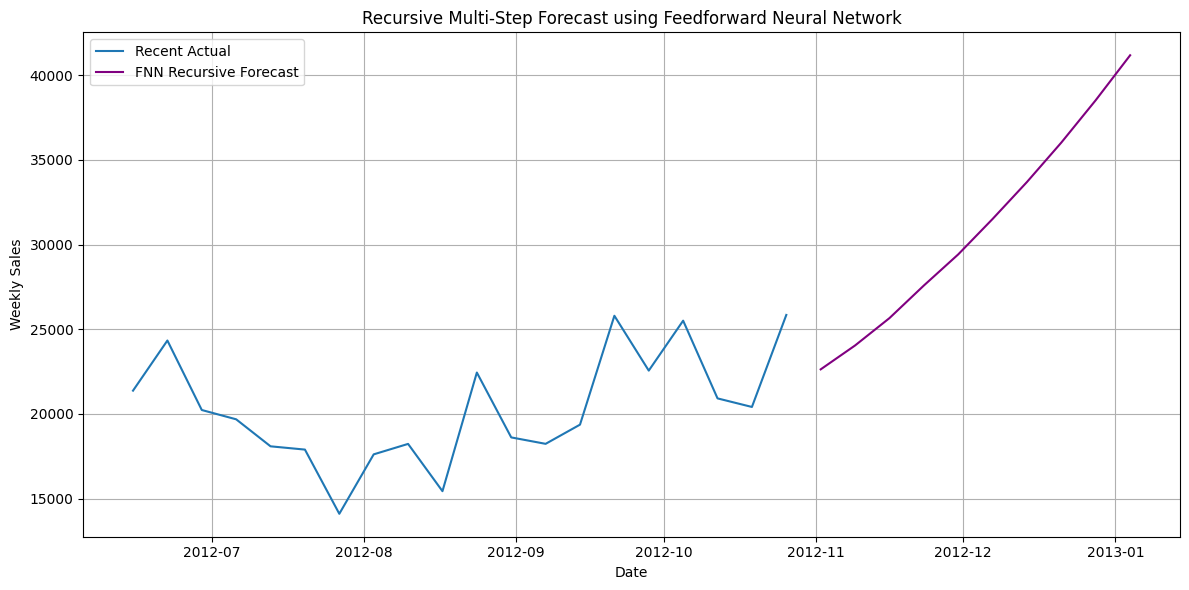

In [105]:
# Generate future date index
future_dates = pd.date_range(start=ml_df.index[-1] + pd.Timedelta(weeks=1), periods=n_steps, freq='W-FRI')

plt.figure(figsize=(12, 6))
plt.plot(ml_df.index[-20:], ml_df['Weekly_Sales'].tail(20), label='Recent Actual')
plt.plot(future_dates, nn_recursive_preds, label='FNN Recursive Forecast', color='purple')
plt.title('Recursive Multi-Step Forecast using Feedforward Neural Network')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
# Save FNN model
model.save('best_fnn_model.h5')

In [107]:
model.save('best_fnn_model.keras')

- CNN Multi-Step Forcasting

In [121]:
def recursive_forecast_cnn(model, last_known_df, exog_future, forecast_steps=10):
    predictions = []
    lags = list(last_known_df[['lag_1', 'lag_2', 'lag_3']].iloc[-1])

    for i in range(forecast_steps):
        exog_row = exog_future.iloc[i]
        input_features = list(exog_row) + lags
        input_array = np.array(input_features).reshape(1, 1, len(input_features))  # CNN expects 3D

        # Predict
        pred = model.predict(input_array, verbose=0)[0][0]
        predictions.append(pred)

        # Update lags
        lags = [pred] + lags[:-1]

    return predictions


In [122]:
# Forecast n steps ahead
n_steps = 10

# Use last row with lag values
last_known_cnn = ml_df.copy().iloc[-1:]

# Repeat last exogenous values for future
exog_future_cnn = last_known_cnn[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']].copy()
exog_future_cnn = pd.concat([exog_future_cnn] * n_steps).reset_index(drop=True)

# Forecast
cnn_recursive_preds = recursive_forecast_cnn(model=cnn_model,
                                             last_known_df=ml_df,
                                             exog_future=exog_future_cnn,
                                             forecast_steps=n_steps)


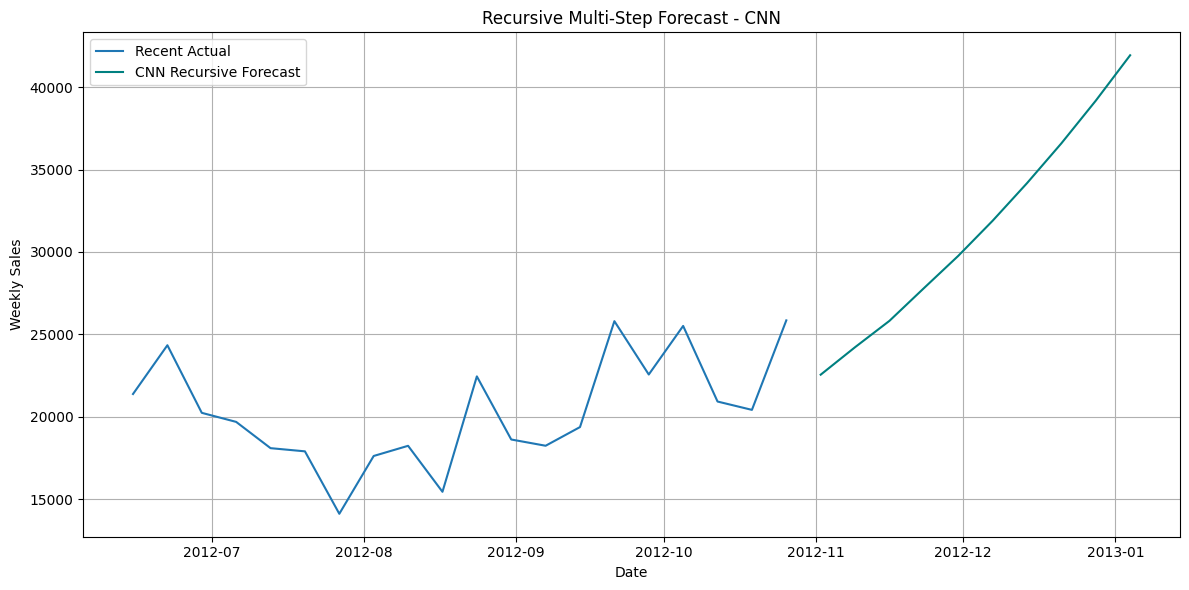

In [123]:
# Future date range
future_dates = pd.date_range(start=ml_df.index[-1] + pd.Timedelta(weeks=1), periods=n_steps, freq='W-FRI')

plt.figure(figsize=(12, 6))
plt.plot(ml_df.index[-20:], ml_df['Weekly_Sales'].tail(20), label='Recent Actual')
plt.plot(future_dates, cnn_recursive_preds, label='CNN Recursive Forecast', color='teal')
plt.title('Recursive Multi-Step Forecast - CNN')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
cnn_model.save('cnn_forecasting_model.keras')

---

#### **Facebook Prophet**

In [126]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2010-02-26 to 2012-10-26
Freq: W-FRI
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     140 non-null    int64  
 1   Dept          140 non-null    float64
 2   Weekly_Sales  140 non-null    float64
 3   Temperature   140 non-null    float64
 4   Fuel_Price    140 non-null    float64
 5   CPI           140 non-null    float64
 6   Unemployment  140 non-null    float64
 7   lag_1         140 non-null    float64
 8   lag_2         140 non-null    float64
 9   lag_3         140 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 12.0 KB


In [127]:
# Prepare Prophet input
prophet_df = ml_df.reset_index()[['Date', 'Weekly_Sales']].rename(columns={
    'Date': 'ds',
    'Weekly_Sales': 'y'
})

In [128]:
# Initialize model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit
prophet_model.fit(prophet_df)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (c:\Users\Hend-PC\anaconda3\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
DEBUG:cmdstanpy:input tempfile: C:\Users\Hend-PC\AppData\Local\Temp\tmpfddhzqh7\yn3k9ydz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Hend-PC\AppData\Local\Temp\tmpfddhzqh7\zom32zld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Hend-PC\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43920', 'data', 'file=C:\\Users\\Hend-PC\\AppData\\Local\\Temp\\tmpfddhzqh7\\yn3k9ydz.json', 'init=C:\\Users\\Hend-PC\\AppData\\Local\\Temp\\tmpfddhzqh7\\zom32zld.json', 'output', 'file=C:\\Users\\Hend-PC\\AppData\\Local\\Temp\\tmpfddhzqh7\\prophet_model4fm0q1ew\\prophet_model-20250620224431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:31 - cmdstanpy - INFO - Chain [1] start processing

In [129]:
# Create future dataframe for next 10 weeks
future = prophet_model.make_future_dataframe(periods=10, freq='W-FRI')

# Forecast
forecast = prophet_model.predict(future)


In [131]:
fig = plot_plotly(prophet_model, forecast)
fig.update_layout(title='Facebook Prophet Forecast')
fig.show()


In [132]:
# Interactive component plots 
components_fig = plot_components_plotly(prophet_model, forecast)
components_fig.show()

---

- Comparing Prophet to ML/DL Models

In [136]:
# Create same future period length as test set
future_prophet = prophet_model.make_future_dataframe(periods=len(test), freq='W-FRI')

# Forecast
forecast_prophet = prophet_model.predict(future_prophet)

# Align prediction with test period
forecast_test = forecast_prophet.iloc[-len(test):]
y_pred_prophet = forecast_test['yhat'].values
y_true_test = test['Weekly_Sales'].values


In [137]:
rmse_prophet = np.sqrt(mean_squared_error(y_true_test, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true_test, y_pred_prophet)

print(f"Facebook Prophet RMSE: {rmse_prophet:.2f}")
print(f"Facebook Prophet MAE: {mae_prophet:.2f}")


Facebook Prophet RMSE: 17486.18
Facebook Prophet MAE: 13366.34


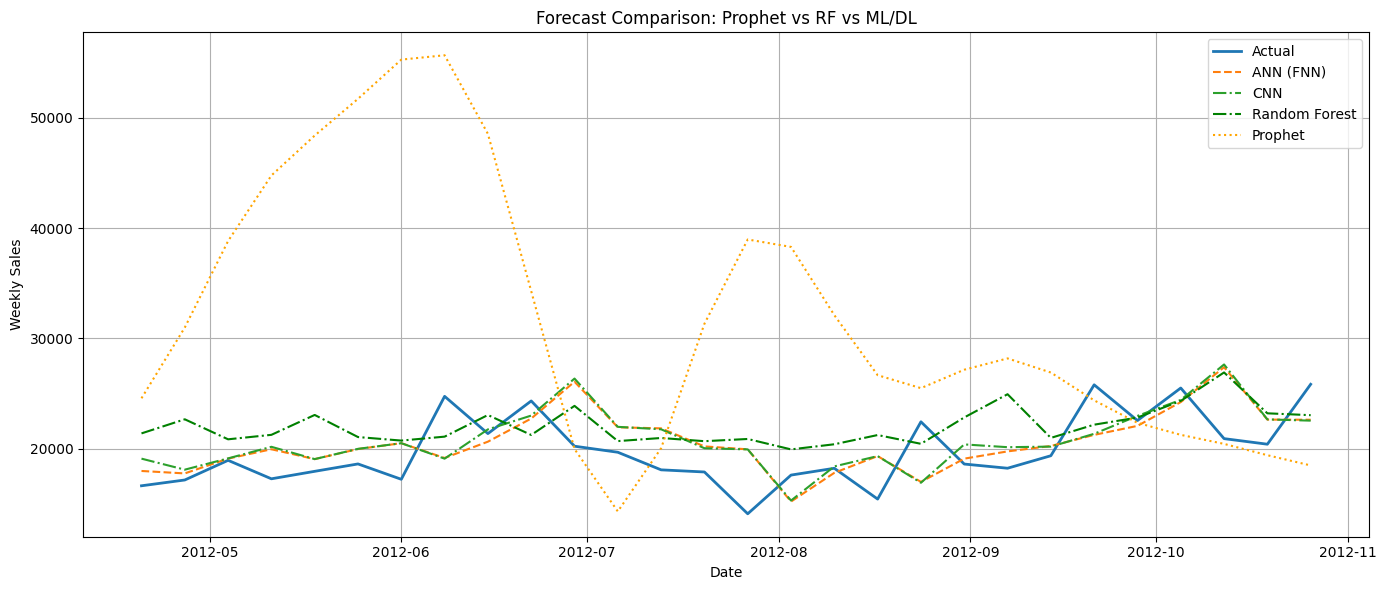

In [139]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, y_test, label='Actual', linewidth=2)
plt.plot(test.index, nn_preds, label='ANN (FNN)', linestyle='--')
plt.plot(test.index, cnn_preds, label='CNN', linestyle='-.')
plt.plot(test.index, rf_preds, label='Random Forest', linestyle='dashdot', color='green')
plt.plot(test.index, y_pred_prophet, label='Prophet', linestyle=':', color='orange')
plt.title('Forecast Comparison: Prophet vs RF vs ML/DL')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

| Model             | RMSE      | MAE       |
|------------------|-----------|-----------|
| **ANN (FNN)**     | 3186.07   | 2561.58   |
| **CNN**           | 3267.31   | 2653.90   |
| **Random Forest** | 3772.52   | 3366.71   |
| **Prophet**       | 17486.18 | 13366.34 |

--> so the best model so far is ANN (FNN)

with RMSE = 3186.07 and MAE = 2561.58

---

#### **Innovative Model** 

will use Temporal Fusion Transformers (TFT)

In [36]:
dep5_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Freq: W-FRI
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     143 non-null    int64  
 1   Dept          143 non-null    float64
 2   Weekly_Sales  143 non-null    float64
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 8.9 KB


In [37]:
dep5_df['Dept'] = dep5_df['Dept'].astype(str)
dep5_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Freq: W-FRI
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IsHoliday     143 non-null    int64  
 1   Dept          143 non-null    object 
 2   Weekly_Sales  143 non-null    float64
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.9+ KB


In [44]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import pytorch_forecasting as ptf
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

In [88]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [45]:
torch.manual_seed(42)
pl.seed_everything(42)

Seed set to 42


42

In [55]:
tft_data = dep5_df.copy()
tft_data = tft_data.reset_index()

tft_data['time_idx'] = range(len(tft_data))  # Sequential time index
tft_data['group'] = 'dept_5'
tft_data['target'] = tft_data['Weekly_Sales']  # Target variable

# Convert categorical columns to string type
tft_data['IsHoliday'] = tft_data['IsHoliday'].astype(str)
tft_data['Dept'] = tft_data['Dept'].astype(str)

# Create lag features
for lag in [1, 2, 4, 8]:
    tft_data[f'sales_lag_{lag}'] = tft_data['target'].shift(lag)

# Create rolling mean features
for window in [4, 8, 12]:
    tft_data[f'sales_rolling_mean_{window}'] = tft_data['target'].rolling(window=window).mean()

# Create date features
tft_data['month'] = tft_data['Date'].dt.month
tft_data['quarter'] = tft_data['Date'].dt.quarter
tft_data['week_of_year'] = tft_data['Date'].dt.isocalendar().week

In [56]:
tft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   143 non-null    datetime64[ns]
 1   IsHoliday              143 non-null    object        
 2   Dept                   143 non-null    object        
 3   Weekly_Sales           143 non-null    float64       
 4   Temperature            143 non-null    float64       
 5   Fuel_Price             143 non-null    float64       
 6   CPI                    143 non-null    float64       
 7   Unemployment           143 non-null    float64       
 8   time_idx               143 non-null    int64         
 9   group                  143 non-null    object        
 10  target                 143 non-null    float64       
 11  sales_lag_1            142 non-null    float64       
 12  sales_lag_2            141 non-null    float64       
 13  sales

In [57]:
# Drop rows with NaN values created by lag/rolling features
tft_data = tft_data.dropna().reset_index(drop=True)
tft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   132 non-null    datetime64[ns]
 1   IsHoliday              132 non-null    object        
 2   Dept                   132 non-null    object        
 3   Weekly_Sales           132 non-null    float64       
 4   Temperature            132 non-null    float64       
 5   Fuel_Price             132 non-null    float64       
 6   CPI                    132 non-null    float64       
 7   Unemployment           132 non-null    float64       
 8   time_idx               132 non-null    int64         
 9   group                  132 non-null    object        
 10  target                 132 non-null    float64       
 11  sales_lag_1            132 non-null    float64       
 12  sales_lag_2            132 non-null    float64       
 13  sales

In [58]:
tft_data['time_idx'] = range(len(tft_data))

print(f"TFT dataset shape: {tft_data.shape}")
print(f"Features: {tft_data.columns.tolist()}")

TFT dataset shape: (132, 21)
Features: ['Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'time_idx', 'group', 'target', 'sales_lag_1', 'sales_lag_2', 'sales_lag_4', 'sales_lag_8', 'sales_rolling_mean_4', 'sales_rolling_mean_8', 'sales_rolling_mean_12', 'month', 'quarter', 'week_of_year']


In [60]:
categorical_cols = ['group', 'IsHoliday', 'Dept']
for col in categorical_cols:
    if col in tft_data.columns:
        tft_data[col] = tft_data[col].astype(str)

print(f"Data types:")
print(tft_data.dtypes)

Data types:
Date                     datetime64[ns]
IsHoliday                        object
Dept                             object
Weekly_Sales                    float64
Temperature                     float64
Fuel_Price                      float64
CPI                             float64
Unemployment                    float64
time_idx                          int64
group                            object
target                          float64
sales_lag_1                     float64
sales_lag_2                     float64
sales_lag_4                     float64
sales_lag_8                     float64
sales_rolling_mean_4            float64
sales_rolling_mean_8            float64
sales_rolling_mean_12           float64
month                             int32
quarter                           int32
week_of_year                     UInt32
dtype: object


In [61]:
tft_data.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,time_idx,group,...,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_8,sales_rolling_mean_4,sales_rolling_mean_8,sales_rolling_mean_12,month,quarter,week_of_year
0,2010-04-23,0,5.0,24763.98,64.84,2.795,210.439123,7.808,0,dept_5,...,11570.27,18516.45,38971.89,24101.89,21204.6550,23875.51750,25285.374167,4,2,16
1,2010-04-30,0,5.0,22006.41,67.41,2.780,210.389546,7.808,1,dept_5,...,24763.98,11570.27,29967.92,23082.14,19214.2775,23741.05125,24433.460000,4,2,17
2,2010-05-07,0,5.0,19260.44,72.55,2.835,210.339968,7.808,2,dept_5,...,22006.41,24763.98,18516.45,21498.92,19400.2750,23461.24125,23570.095833,5,2,18
3,2010-05-14,0,5.0,16891.66,74.78,2.854,210.337426,7.808,3,dept_5,...,19260.44,22006.41,11570.27,22632.57,20730.6225,22743.62750,22772.045000,5,2,19
4,2010-05-21,0,5.0,16157.17,76.44,2.826,210.617093,7.808,4,dept_5,...,16891.66,19260.44,24763.98,38971.89,18578.9200,19891.78750,22109.985000,5,2,20


In [89]:
print("\nUsing LSTM-based alternative (TFT-inspired)...")
# Prepare data for LSTM
def create_sequences(data, seq_length, pred_length):
        sequences = []
        targets = []
        
        feature_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
        
        # Convert categorical to numeric
        data_numeric = data.copy()
        data_numeric['IsHoliday'] = data_numeric['IsHoliday'].astype(int)
        
        for i in range(seq_length, len(data) - pred_length + 1):
            # Features sequence
            feat_seq = data_numeric[feature_cols].iloc[i-seq_length:i].values
            target_seq = data_numeric['target'].iloc[i-seq_length:i].values.reshape(-1, 1)
            
            # Combine features and target
            seq = np.concatenate([feat_seq, target_seq], axis=1)
            sequences.append(seq)
            
            # Target (next pred_length values)
            targets.append(data_numeric['target'].iloc[i:i+pred_length].values)
            
        return np.array(sequences), np.array(targets)


Using LSTM-based alternative (TFT-inspired)...


In [91]:
seq_length = 24    
pred_length = 12
X, y = create_sequences(tft_data, seq_length, pred_length)

In [92]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [93]:
# Normalize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

In [94]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)

In [95]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)    

In [96]:
# Define TFT-inspired LSTM model
class TFTInspiredLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
            super(TFTInspiredLSTM, self).__init__()
            
            # Multi-head attention simulation
            self.attention = nn.MultiheadAttention(embed_dim=input_size, num_heads=2, dropout=dropout)
            
            # LSTM layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
            
            # Feed-forward network
            self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
            self.fc2 = nn.Linear(hidden_size // 2, output_size)
            self.dropout = nn.Dropout(dropout)
            self.relu = nn.ReLU()
            
        def forward(self, x):
            # x shape: (batch_size, seq_len, features)
            
            # Apply attention (simplified)
            x_att = x.transpose(0, 1)  # (seq_len, batch_size, features)
            attn_output, _ = self.attention(x_att, x_att, x_att)
            x_att = attn_output.transpose(0, 1)  # Back to (batch_size, seq_len, features)
            
            # Combine original and attention
            x_combined = x + x_att
            
            # LSTM processing
            lstm_out, _ = self.lstm(x_combined)
            
            # Use last output for prediction
            last_output = lstm_out[:, -1, :]
            
            # Feed-forward layers
            x = self.relu(self.fc1(last_output))
            x = self.dropout(x)
            output = self.fc2(x)
            
            return output

In [97]:
# Initialize model
input_size = X_train.shape[-1]  # Number of features
hidden_size = 64
num_layers = 2
output_size = pred_length
    
model = TFTInspiredLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    
print(f"TFT-inspired LSTM model created with {sum(p.numel() for p in model.parameters())/1e3:.1f}k parameters")
    

TFT-inspired LSTM model created with 54.4k parameters


In [99]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
print("TFT-inspired LSTM training completed!")

Epoch [10/50], Train Loss: 0.7574, Val Loss: 0.1381
Epoch [20/50], Train Loss: 0.5677, Val Loss: 0.0752
Epoch [30/50], Train Loss: 0.4861, Val Loss: 0.0670
Epoch [40/50], Train Loss: 0.4478, Val Loss: 0.0728
Epoch [50/50], Train Loss: 0.3923, Val Loss: 0.0685
TFT-inspired LSTM training completed!


In [100]:
# Make predictions
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)

In [101]:
# Inverse transform predictions
pred_values = scaler_y.inverse_transform(val_predictions.numpy())
actual_values = scaler_y.inverse_transform(y_val_scaled)

In [102]:
# Flatten for evaluation
pred_flat = pred_values.flatten()
actual_flat = actual_values.flatten()

In [104]:
mae = mean_absolute_error(actual_flat, pred_flat)
mse = mean_squared_error(actual_flat, pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_flat, pred_flat)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")

MAE: 2366.94
RMSE: 3247.98
MAPE: 0.11


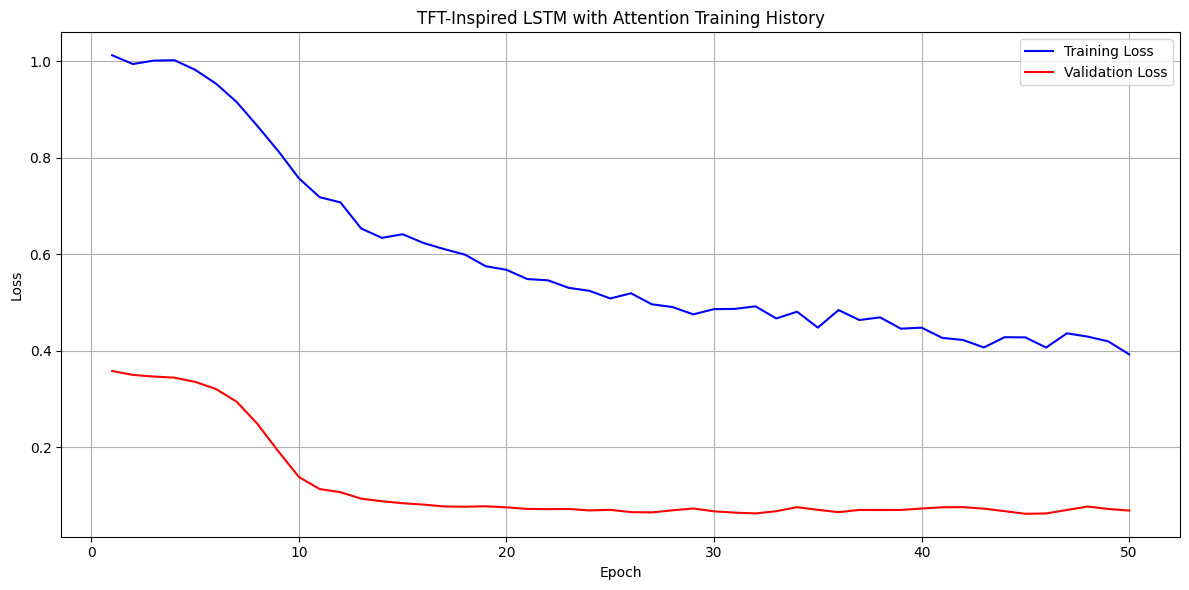

In [105]:
model_name = "TFT-Inspired LSTM with Attention"

fig, ax = plt.subplots(figsize=(12, 6))
epochs = range(1, len(train_losses) + 1)
ax.plot(epochs, train_losses, 'b-', label='Training Loss')
ax.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'{model_name} Training History')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

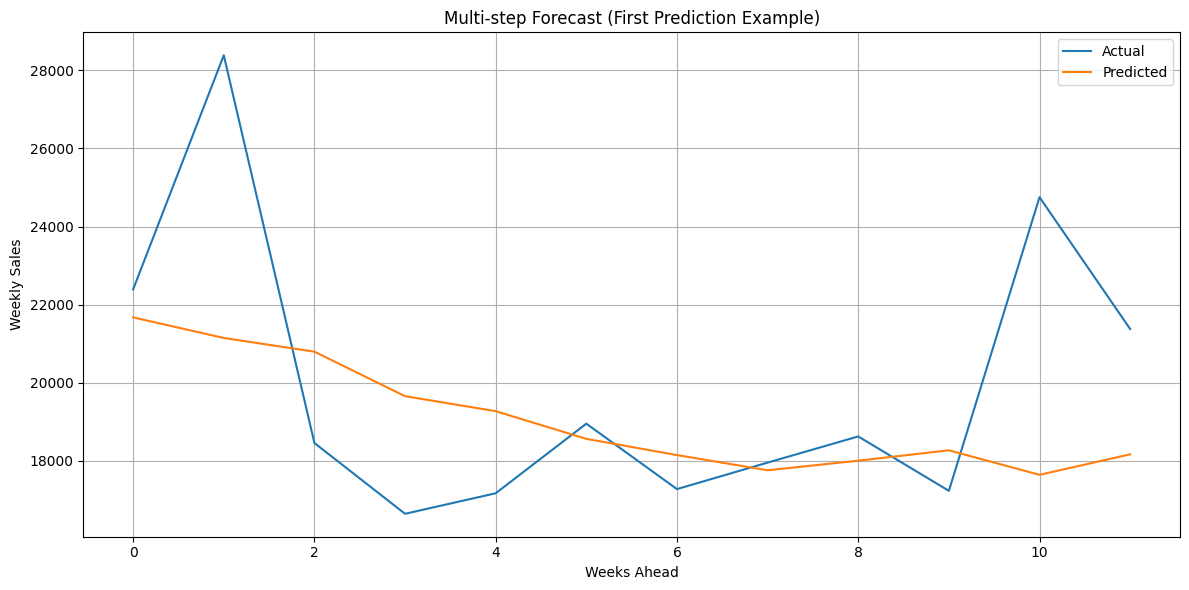

In [115]:
# Plot the first prediction set (12 steps ahead)
plt.figure(figsize=(12, 6))
plt.plot(actual_values[0], label='Actual')
plt.plot(pred_values[0], label='Predicted')
plt.title("Multi-step Forecast (First Prediction Example)")
plt.xlabel("Weeks Ahead")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


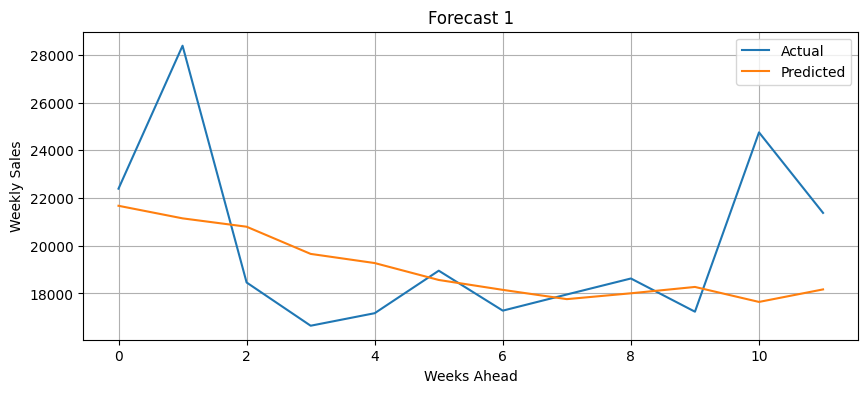

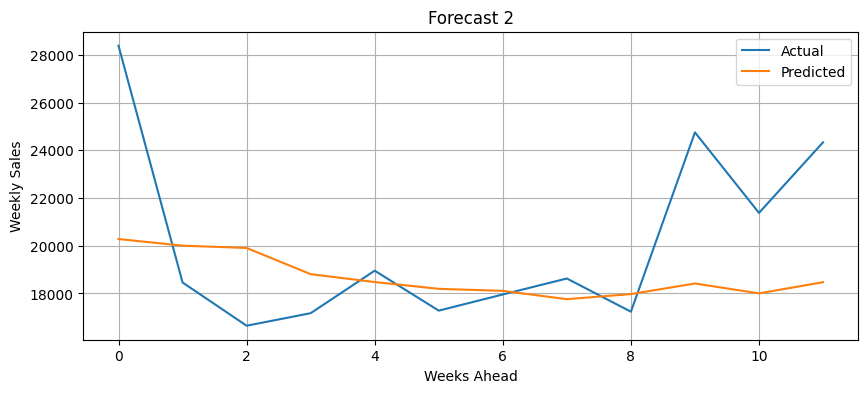

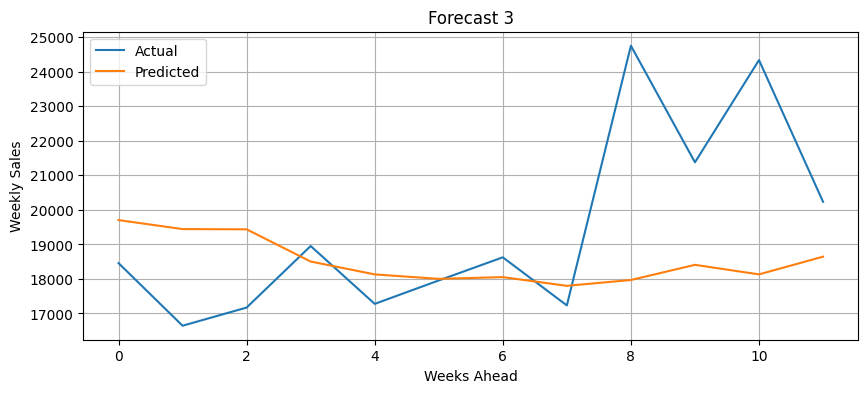

In [116]:
for i in range(3):  # show 3 examples
    plt.figure(figsize=(10, 4))
    plt.plot(actual_values[i], label='Actual')
    plt.plot(pred_values[i], label='Predicted')
    plt.title(f"Forecast {i+1}")
    plt.xlabel("Weeks Ahead")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(True)
    plt.show()


In [118]:
print("📌 Model Configuration Summary")
print(f"- Sequence length: {seq_length}")
print(f"- Prediction length: {pred_length}")
print(f"- Hidden size: {hidden_size}")
print(f"- Layers: {num_layers}")
print(f"- Input features: {input_size}")
print(f"- Parameters: {sum(p.numel() for p in model.parameters())}")

📌 Model Configuration Summary
- Sequence length: 24
- Prediction length: 12
- Hidden size: 64
- Layers: 2
- Input features: 6
- Parameters: 54356


In [119]:
# Save predictions to CSV
output_df = pd.DataFrame(pred_values, columns=[f"pred_week_{i+1}" for i in range(pred_length)])
actual_df = pd.DataFrame(actual_values, columns=[f"actual_week_{i+1}" for i in range(pred_length)])
combined_df = pd.concat([output_df, actual_df], axis=1)
combined_df.to_csv("tft_lstm_forecasts.csv", index=False)

print("✅ Predictions saved to 'tft_lstm_forecasts.csv'")

✅ Predictions saved to 'tft_lstm_forecasts.csv'


In [120]:
# Save the model's state_dict (weights only)
MODEL_PATH = "tft_lstm_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH}")

✅ Model saved to: tft_lstm_model.pth


In [122]:
# # Re-initialize the model with same architecture
# model_loaded = TFTInspiredLSTM(input_size, hidden_size, num_layers, output_size)

# # Load the saved weights
# model_loaded.load_state_dict(torch.load("tft_lstm_model.pth"))
# model_loaded.eval()

# print("✅ Model loaded successfully and ready for inference.")

In [121]:
torch.save(model, "tft_lstm_model_full.pth")

#### **Choosing Best Model for Deployment**

| Model             | RMSE      | MAE       |
|------------------|-----------|-----------|
| **ANN (FNN)**     | 3186.07   | 2561.58   |
| **CNN**           | 3267.31   | 2653.90   |
| **Random Forest** | 3772.52   | 3366.71   |
| **Prophet**       | 17486.18 | 13366.34 |
| **TFT-LSTM**         | 3247.98 | 2366.94 |

So, I will Choose TFT-LSTM